In [170]:
import os
import psycopg2
from dotenv import load_dotenv
from sshtunnel import SSHTunnelForwarder
import time
import pandas as pd
import numpy as np
import statsmodels
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [171]:
# Load environment variables from .env file
load_dotenv("environment_variables.env")
psql_pw = os.getenv("PSQL_PW")

# Get data
## DB Connection

In [172]:
# Connect to AWS RDS instance through AWS EC2 instance

# SSH parameters
bastion_host = 'ec2-34-224-93-62.compute-1.amazonaws.com'
bastion_user = 'ec2-user'
# bastion_key = 'C:\\Users\\detto\\Documents\\ec2-key-pair.pem'
bastion_key = "/Users/adettor/Documents/YouTubeViewPrediction/ec2-key-pair.pem"

# RDS parameters
rds_host = 'youtubeviewprediction.cd0c8oow2pnr.us-east-1.rds.amazonaws.com'
rds_user = 'postgres'
rds_password = psql_pw
rds_database = 'YouTubeViewPrediction'
rds_port = 5432

try:
    # Create an SSH tunnel
    tunnel = SSHTunnelForwarder(
        (bastion_host, 22),
        ssh_username=bastion_user,
        ssh_pkey=bastion_key,
        remote_bind_address=(rds_host, rds_port),
        local_bind_address=('localhost', 6543)  # Choose a local port for the tunnel
    )

    # Start the tunnel
    tunnel.start()

    # Connect to PostgreSQL through the tunnel
    conn = psycopg2.connect(
        database=rds_database,
        user=rds_user,
        password=rds_password,
        host=tunnel.local_bind_host,
        port=tunnel.local_bind_port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a SQL query
    cursor.execute("SELECT version();")

    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record)

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL:", error)

You are connected to -  ('PostgreSQL 16.1 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',)


## Turn SQL tables in to Pandas dataframes

In [173]:
video_fact = pd.read_sql_query("SELECT * FROM video_fact", conn)
video_dim = pd.read_sql_query("SELECT * FROM video_dim", conn)
channel_fact = pd.read_sql_query("SELECT * FROM channel_fact", conn)
channel_dim = pd.read_sql_query("SELECT * FROM channel_dim", conn)
categories_dim = pd.read_sql_query("SELECT * FROM categories_dim", conn)

In [174]:
conn.close()
cursor.close()
tunnel.stop()

# EDA
## video_fact

In [175]:
video_fact.shape

(130042, 5)

In [176]:
video_fact.dtypes

collected_at    datetime64[ns]
video_id                object
num_views                int64
num_likes                int64
num_comments             int64
dtype: object

In [177]:
video_fact.describe()

,collected_at,num_views,num_likes,num_comments
count,130042,1.300420e+05,1.300420e+05,130042.000000
mean,2024-08-05 20:44:47.071714816,2.908895e+06,1.088465e+05,7140.928861
min,2024-07-20 21:00:06.211863,3.034000e+04,0.000000e+00,0.000000
25%,2024-07-31 15:00:06.081110016,5.150060e+05,1.325100e+04,1022.000000
50%,2024-08-06 21:00:05.508131072,1.012546e+06,3.206950e+04,2412.000000
75%,2024-08-11 21:00:05.789771008,2.131694e+06,7.762775e+04,4970.000000
max,2024-08-15 21:00:05.455278,2.231494e+08,8.383907e+06,385935.000000
std,NaN,1.113429e+07,4.885892e+05,27051.464290


Some videos have 0 likes and/or 0 comments

In [178]:
video_fact[["collected_at", "video_id"]].nunique()

collected_at     209
video_id        1073
dtype: int64

In [179]:
video_fact.isna().sum()

collected_at    0
video_id        0
num_views       0
num_likes       0
num_comments    0
dtype: int64

### video_id

In [180]:
id_counts = video_fact["video_id"].value_counts()
id_counts

video_id
laNA2HgwYXU    209
6CXWUjjcQxg    209
GHtIxjKPP9w    209
j7YgKocz2W4    209
O_A8HdCDaWM    209
              ... 
6pbcEj3V38w      1
wCu-o5_uVeo      1
nW9ykk8RRRQ      1
VO2P161QYp0      1
geIVLMXeMeQ      1
Name: count, Length: 1073, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

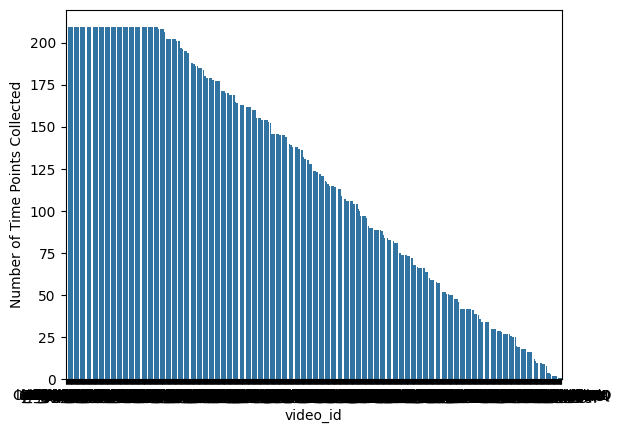

In [181]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [182]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

count
209    200
208     13
206      1
204      1
202     24
      ... 
8        2
4        6
3        6
2       12
1        8
Name: count, Length: 130, dtype: int64

Text(0, 0.5, 'Number of Videos')

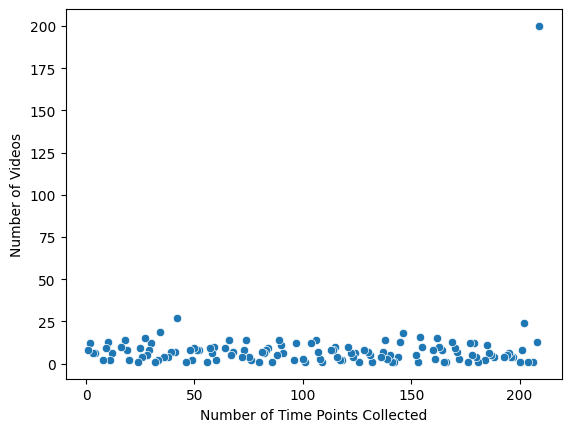

In [183]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

In [184]:
ids = id_counts.sample(15).index
print(ids)

Index(['DX4BE9GmpH4', 'JyHfvk5QHr0', 'Y7oU6VXJOVc', 'epsnfh_Xc2U',
       'ySoHR8dFHGY', 'zYdFLUBjwCU', 'huGd4efgdPA', 'PvXyjz0hdbc',
       'OdxSbc0ap-s', 'kMxuLQWMOLc', '0luAzyPl7DI', 'Q_HXKmGIS3c',
       'yW60in4jGzc', 'S7_0QuGodtE', 'uVJ9t-qw2VY'],
      dtype='object', name='video_id')


### num_views

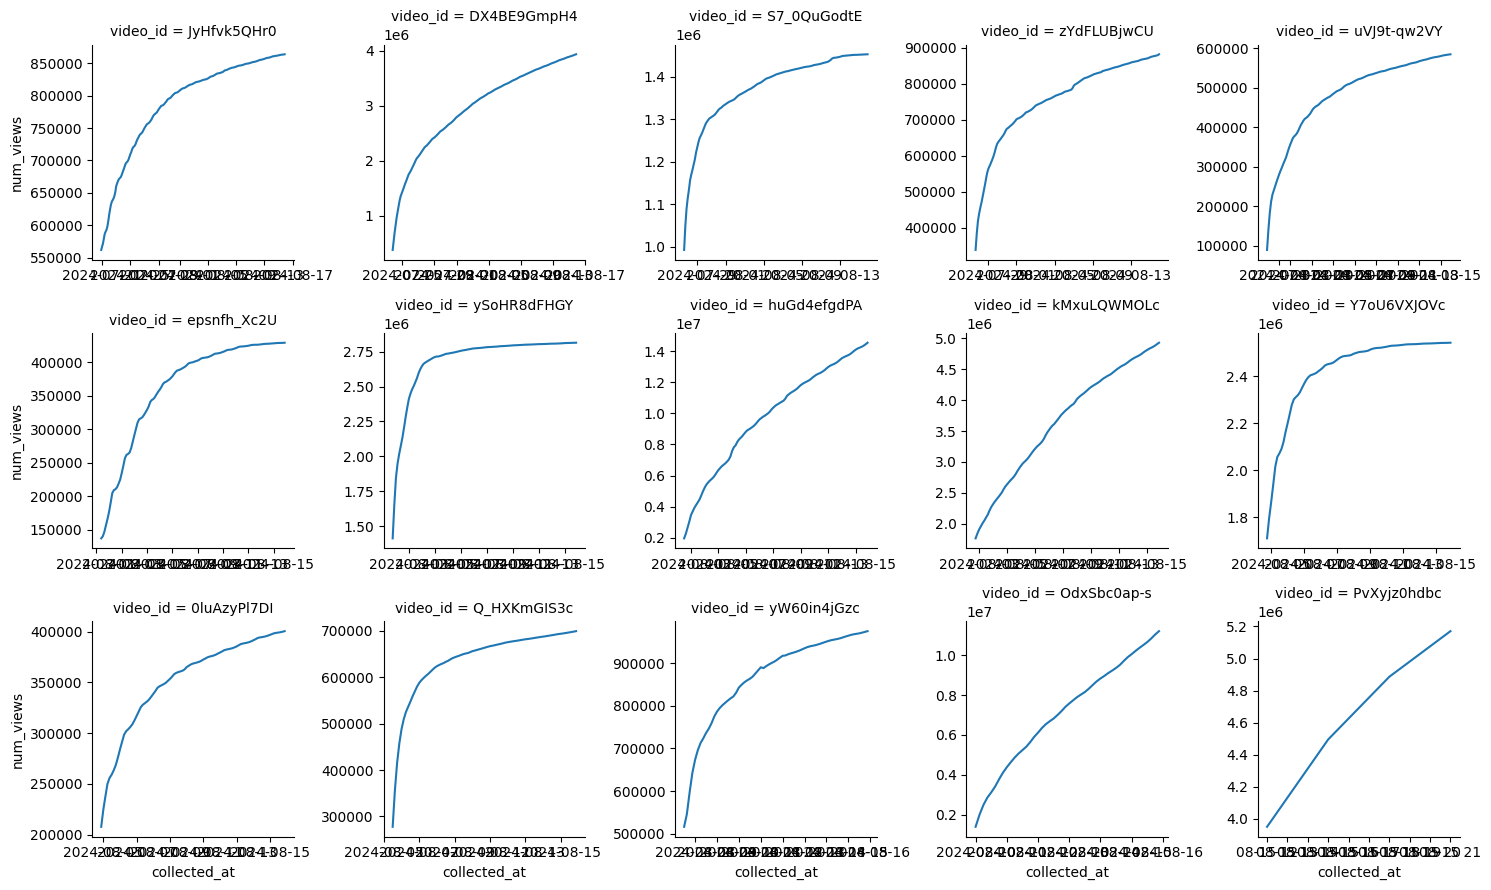

In [185]:
col = "num_views"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_comments

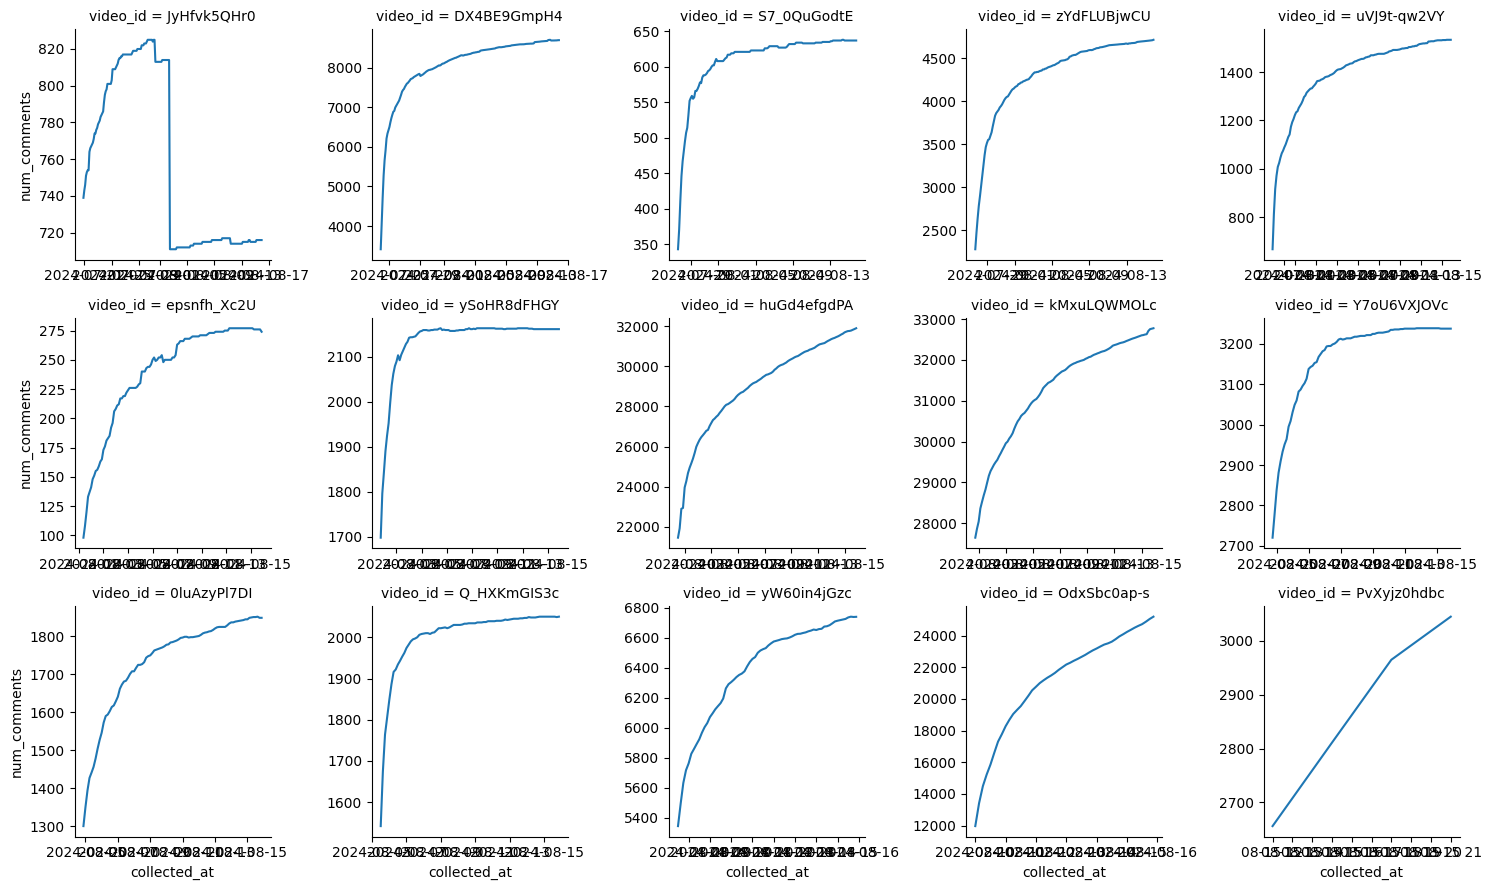

In [186]:
col = "num_comments"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_likes

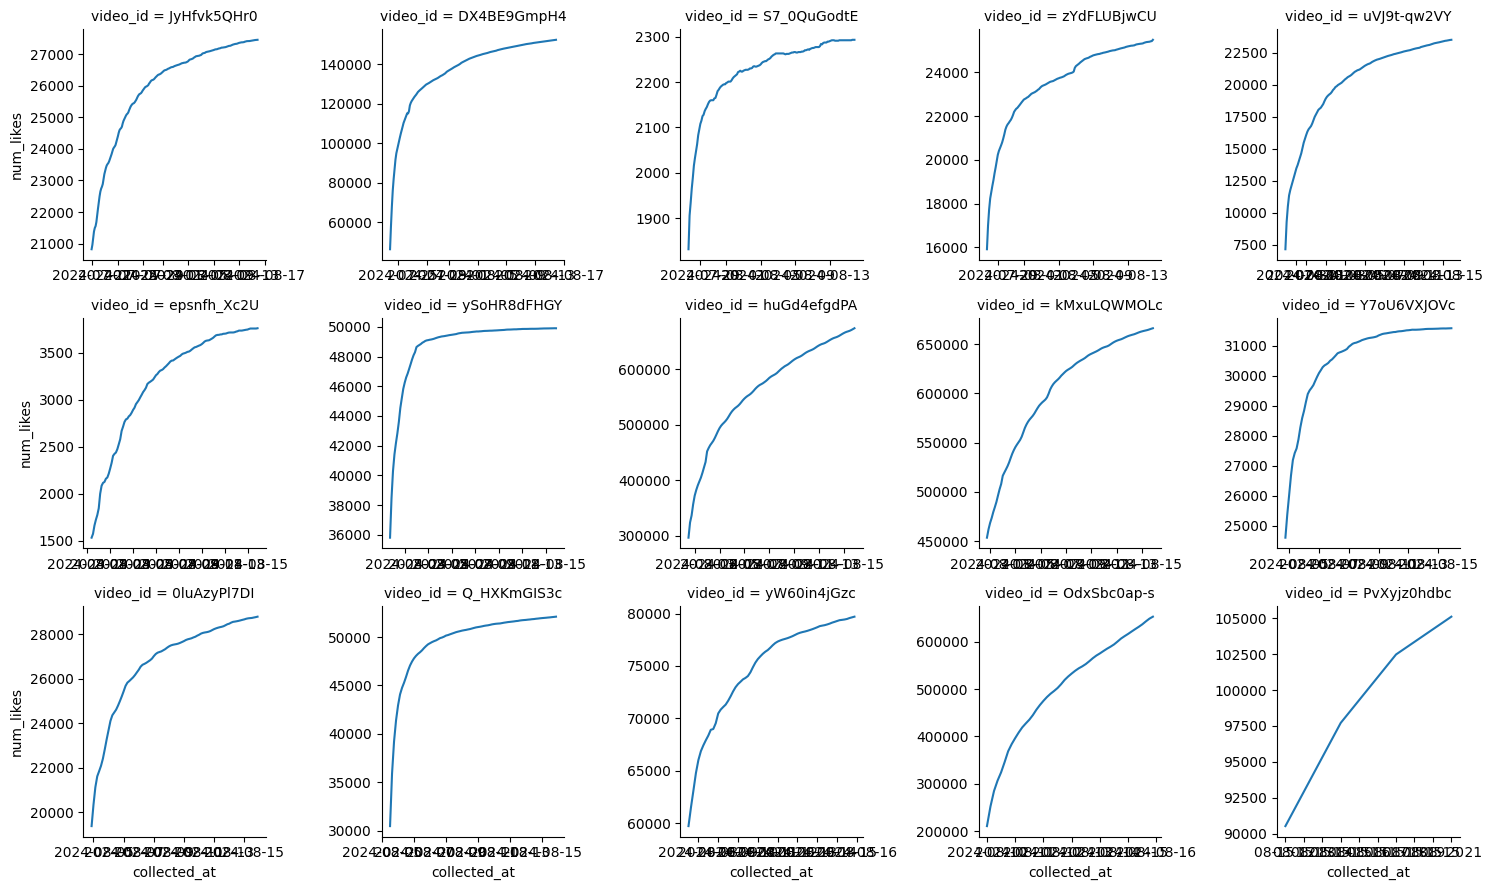

In [187]:
col = "num_likes"
id_data = video_fact.loc[video_fact["video_id"].isin(ids), ["video_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="video_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

## channel_fact

In [188]:
channel_fact.shape

(101382, 5)

In [189]:
channel_fact.dtypes

collected_at           datetime64[ns]
channel_id                     object
channel_total_views             int64
num_subscribers                 int64
num_videos                      int64
dtype: object

In [190]:
channel_fact.describe()

,collected_at,channel_total_views,num_subscribers,num_videos
count,101382,1.013820e+05,1.013820e+05,101382.000000
mean,2024-08-05 09:19:32.996806912,2.322540e+09,5.745883e+06,6195.683642
min,2024-07-20 21:00:07.479465,0.000000e+00,4.000000e+00,1.000000
25%,2024-07-30 21:00:08.435900928,1.666717e+08,6.500000e+05,207.000000
50%,2024-08-06 06:00:08.576058112,6.141470e+08,1.890000e+06,670.000000
75%,2024-08-11 12:00:09.538156032,1.773068e+09,5.400000e+06,2531.000000
max,2024-08-15 21:00:09.539169,8.706858e+10,3.090000e+08,295228.000000
std,NaN,5.779630e+09,1.662017e+07,21757.877486


Some channels have total views hidden. At least one channel has 1 video?!

In [191]:
channel_fact[["collected_at", "channel_id"]].nunique()

collected_at    209
channel_id      763
dtype: int64

In [192]:
channel_fact.isna().sum()

collected_at           0
channel_id             0
channel_total_views    0
num_subscribers        0
num_videos             0
dtype: int64

### channel_id

In [193]:
id_counts = channel_fact["channel_id"].value_counts()
id_counts

channel_id
UC2OREBiIbDChxvmDeg30Bsg    209
UC5sGdW8Jf7ijogDhcIFRmlw    209
UC7ABaoK3AFxuy_i4f6xV1tA    209
UCY6Ij8zOds0WJEeqCLOnqOQ    209
UCJbYdyufHR-cxOuY96KIoqA    209
                           ... 
UCHQU99yKRd_BQVSci2MZ08w      1
UC9B3InnxvWQJzPuKmiftMBQ      1
UCb1Fx7ZjON_6F29taDKEuSQ      1
UC3XTzVzaHQEd30rQbuvCtTQ      1
UCH1oRy1dINbMVp3UFWrKP0w      1
Name: count, Length: 763, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

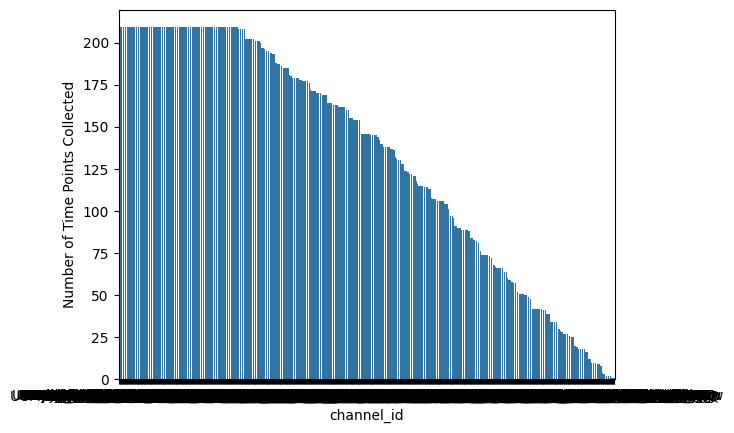

In [194]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [195]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

count
209    183
208     11
202     16
201      8
200      1
      ... 
8        2
4        2
3        3
2        9
1        6
Name: count, Length: 116, dtype: int64

Text(0, 0.5, 'Number of Videos')

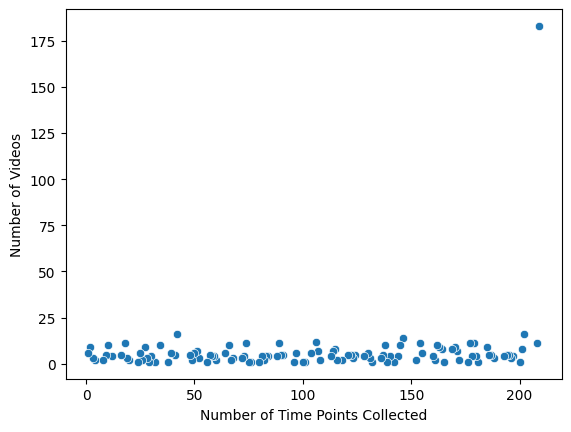

In [196]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

In [197]:
ids = id_counts.sample(15).index
print(ids)

Index(['UCETZ7OiW7-wqwb-6hsz3C4w', 'UC789h3eqw0H1HqGmIsI26OA',
       'UCQjiiuW4u4ZVb8h4ywbH_rg', 'UCo8bcnLyZH8tBIH9V1mLgqQ',
       'UCrzx3ZPXEZpzEGLF1gIuORQ', 'UCMvJjqVlkSJ9x8hJwcfw4nQ',
       'UCG2ZSuJUnKGFNno97fkvdPw', 'UCbD8EppRX3ZwJSou-TVo90A',
       'UCaYxyR9mzVlTrOOyZD0XAmA', 'UC0biFgrMdkv1hFAFLVePODQ',
       'UCQUsq24C0yX_ezzQYj2IjXw', 'UCI2hA8WukW-Q90aabtm3Hbw',
       'UClBrK91MWlsHKRpDxS36qCg', 'UC2wKfjlioOCLP4xQMOWNcgg',
       'UCeekxg1vju_sjIK9KjJJLYg'],
      dtype='object', name='channel_id')


### channel_total_views

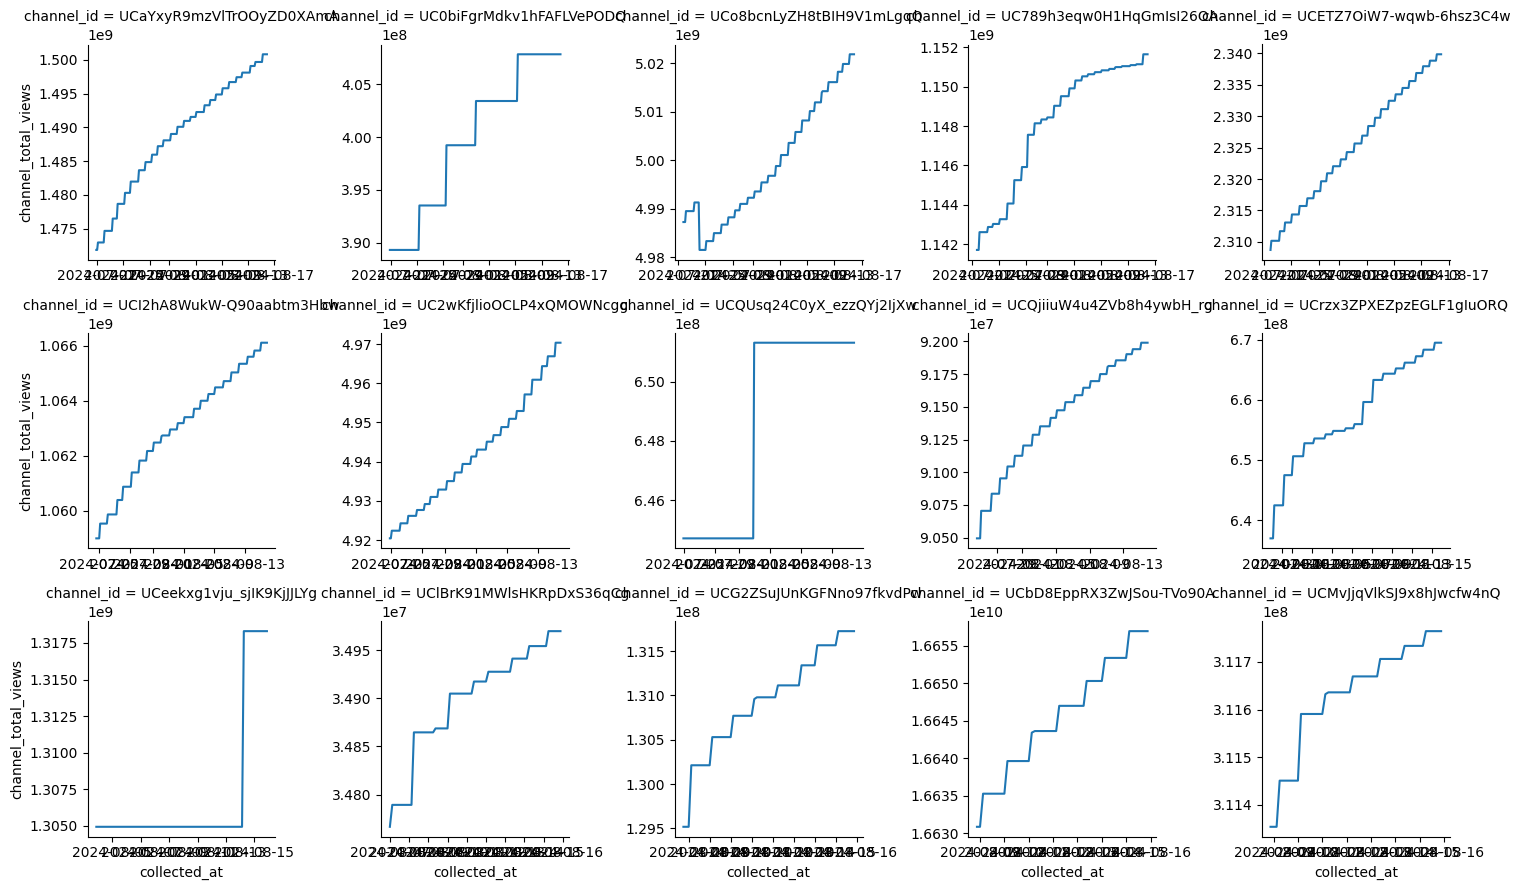

In [198]:
col = "channel_total_views"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_subscribers

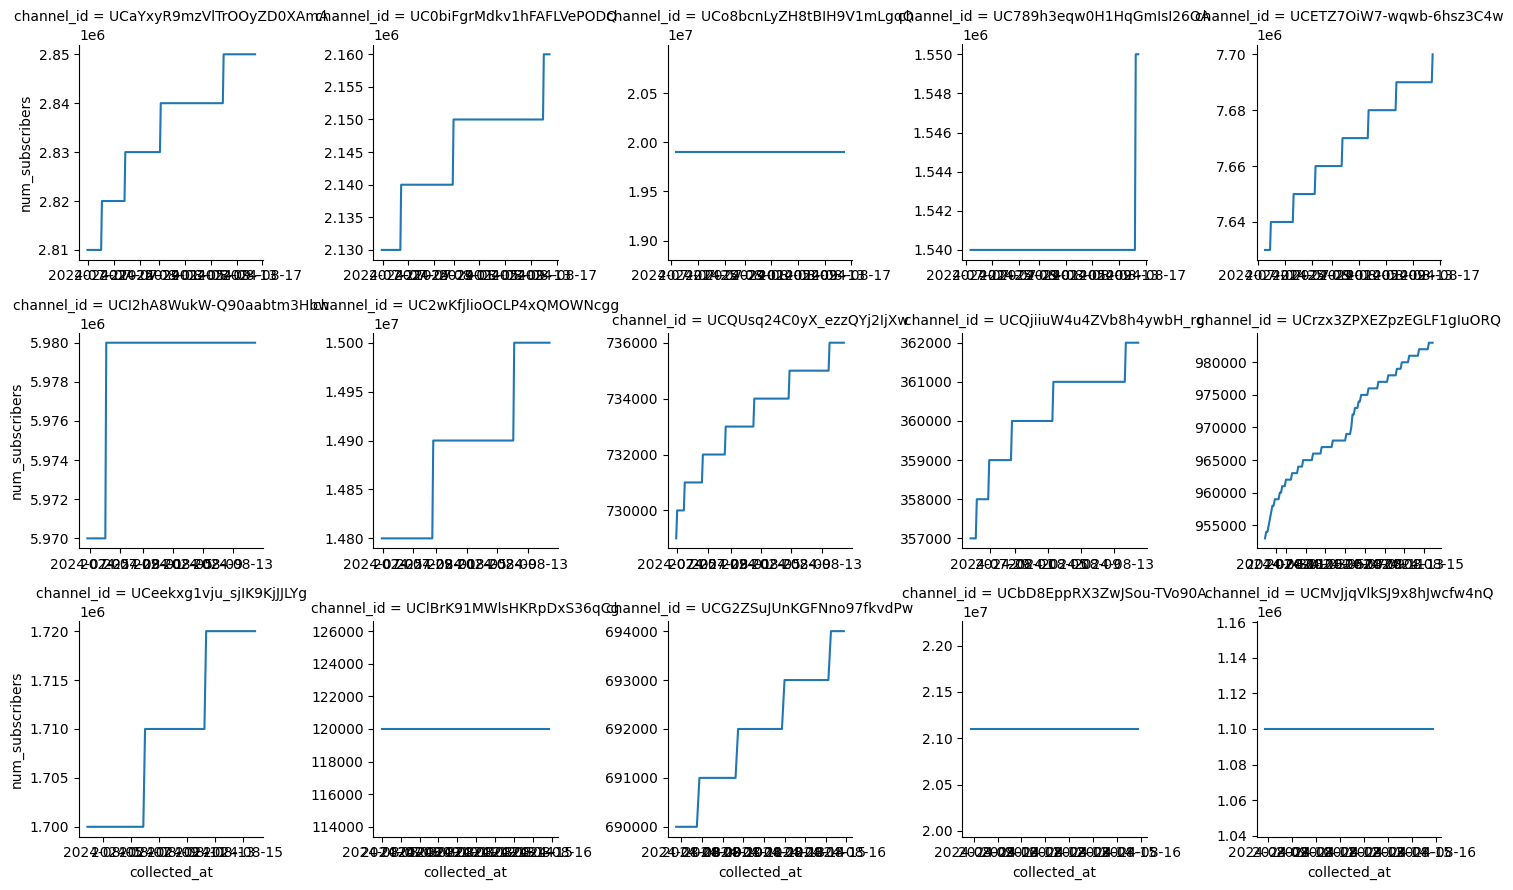

In [199]:
col = "num_subscribers"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

### num_videos

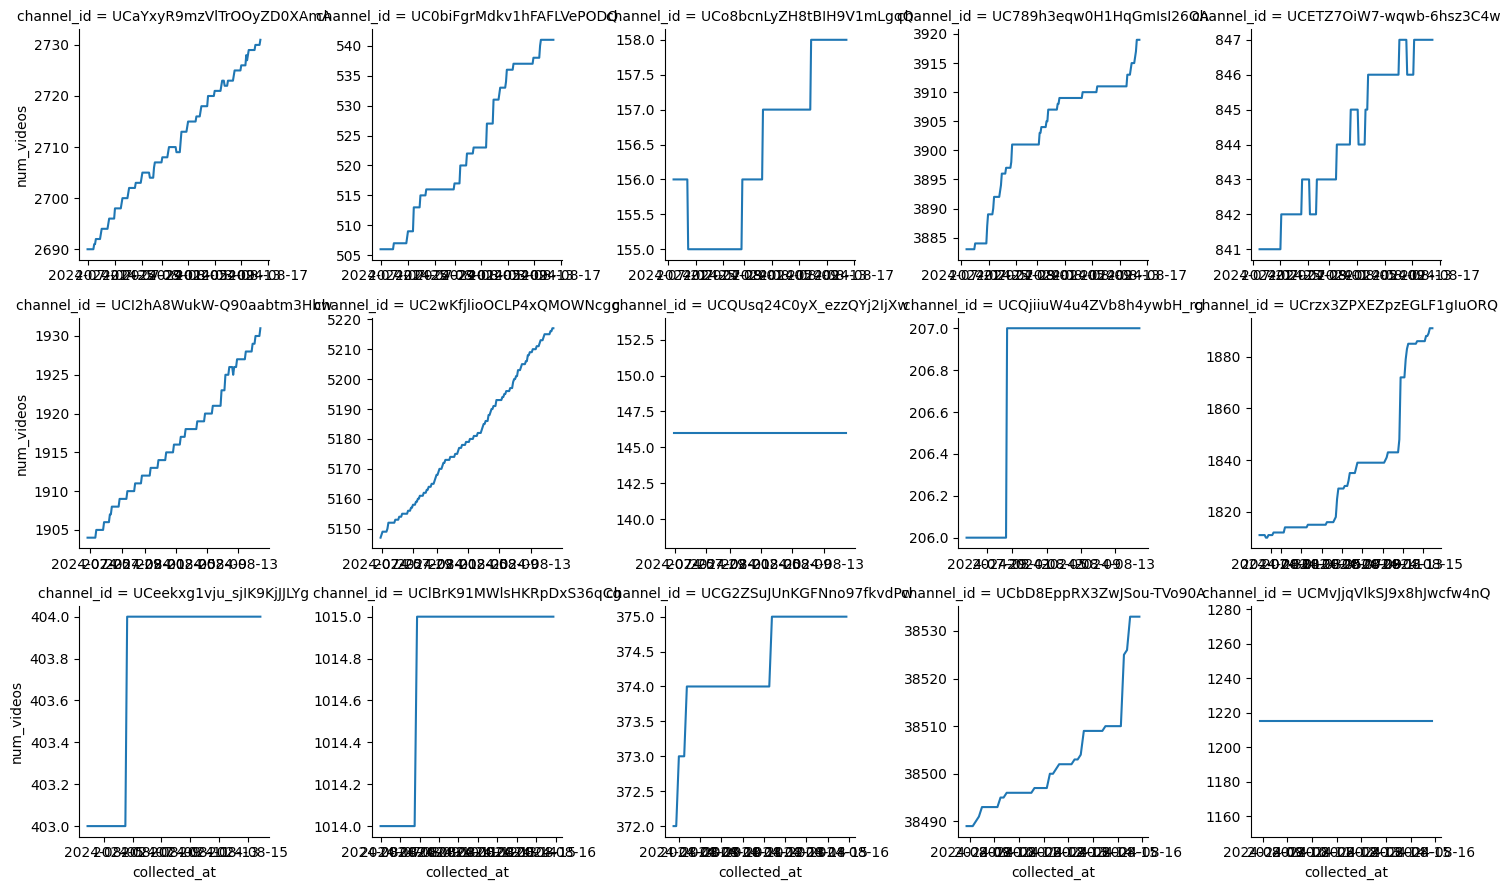

In [200]:
col = "num_videos"
id_data = channel_fact.loc[channel_fact["channel_id"].isin(ids), ["channel_id", "collected_at", col]]
g = sns.FacetGrid(id_data, sharey=False, sharex=False, col="channel_id", col_wrap=5)
g.map(sns.lineplot, "collected_at", col)

## video_dim

In [201]:
video_dim.shape

(1073, 10)

In [202]:
video_dim.dtypes

video_id                     object
channel_id                   object
video_title                  object
video_description            object
num_tags                      int64
duration_seconds              int64
licensed_content               bool
made_for_kids                  bool
published_at         datetime64[ns]
category_id                   int64
dtype: object

In [203]:
video_dim.describe()

,num_tags,duration_seconds,published_at,category_id
count,1073.000000,1073.000000,1073,1073.000000
mean,15.906803,969.612302,2024-07-30 10:12:00.302888960,18.590867
min,0.000000,13.000000,2024-06-26 12:22:40,1.000000
25%,4.000000,198.000000,2024-07-22 15:01:47,17.000000
50%,15.000000,609.000000,2024-07-30 14:00:06,20.000000
75%,25.000000,1398.000000,2024-08-08 03:53:10,24.000000
max,65.000000,26709.000000,2024-08-15 16:00:11,29.000000
std,12.791915,1288.056341,NaN,6.473496


### video_id

In [204]:
video_dim["video_id"].sample(15)

306    d09rPOCa2Zk
816    LwwO8Nx3XF4
116    e8NCcGBdUQg
410    kzp4bSCsloc
404    S7J-rv_OD1g
615    zvmhY_pbXj4
906    RlFF5bZmtqs
884    ws0vT5qKdQY
517    8gDMPU2h2YU
780    VmBzRNP3aLA
403    pvey-kQdqqc
660    1Tf2QTgcK64
927    XW5kYSbAWZY
441    F24RXLfy0Jw
647    5NuhIvcXdMY
Name: video_id, dtype: object

In [205]:
video_dim["video_id"].apply(lambda x: len(x)).value_counts()

video_id
11    1073
Name: count, dtype: int64

### video_title

In [206]:
video_dim["video_title"].sample(15)

314        Inside Mark Zuckerberg's AI Era | The Circuit
601    Unstoppable Simone Biles Wins 6th Gold Medal W...
382                I Built Bikini Bottom in a Fish Tank!
166    Game Theory: We SOLVED Golden Freddy… Again! (...
857             Mufasa: The Lion King | Official Trailer
486    Team USA men's basketball starts Olympic run w...
243                                       unreviewable 2
727                                           Thank You.
552    La Cracka x Foolio - "50K" (Official Music Video)
328    Borderlands (2024) Final Trailer – Cate Blanch...
584    LISA- ROCKSTAR Special Stage Performance (w/ H...
607    Jessie Murph, Teddy Swims - Dirty (Official Vi...
398                                       what's next...
848    Megan Thee Stallion - Mamushi (feat. Yuki Chib...
824    Detroit Lions vs. New York Giants | 2024 Prese...
Name: video_title, dtype: object

In [207]:
video_dim["video_title"].apply(lambda x: len(x)).value_counts()

video_title
49    31
42    29
43    27
46    25
47    24
      ..
16     2
86     2
4      1
88     1
18     1
Name: count, Length: 94, dtype: int64

### video_description

In [208]:
video_dim["video_description"].sample(15)

4       Thanks to ARMRA Colostrum for sponsoring this ...
258     Dave explains the Crowdstrike IT outage, focus...
220                                                      
1021    Watch the goals and highlights as Real Madrid ...
523     NEW MERCH: shop.thebaddy.com\n\nThe official Y...
659     Download ​⁠Game of Thrones Legends now: https:...
635     A run down of the basic mechanics, slinger fun...
116     On Day 1 of the Republican National Convention...
634     Listen to "Leadfoot" from Billy Strings' upcom...
296     🔴 I'M LIVE! https://www.twitch.tv/jasontheween...
980     Going back to Fortnite Chapter 2 was very nost...
1031    In Season 4 of Only Murders in the Building, o...
96      I can’t believe how intense this video got\nTh...
45      I'm back\n\ncobble farm: https://www.youtube.c...
890     BUY THE TACO PLUSHIE: https://www.inanimateins...
Name: video_description, dtype: object

In [209]:
video_dim["video_description"].apply(lambda x: len(x)).value_counts()

video_description
0       7
562     5
568     4
497     4
555     4
       ..
1552    1
2639    1
1488    1
352     1
679     1
Name: count, Length: 833, dtype: int64

### num_tags

<Axes: xlabel='num_tags', ylabel='Count'>

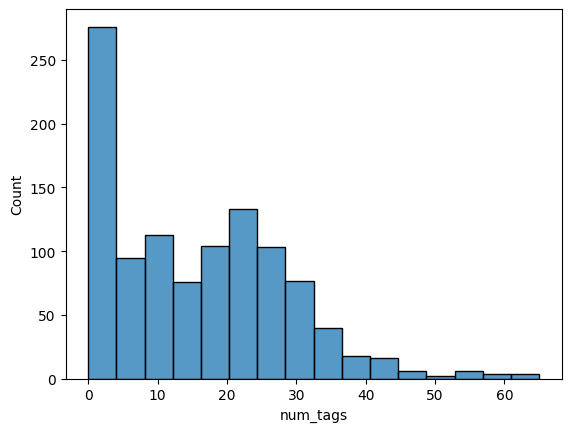

In [210]:
sns.histplot(video_dim, x="num_tags")

### duration_seconds

<Axes: xlabel='duration_seconds', ylabel='Count'>

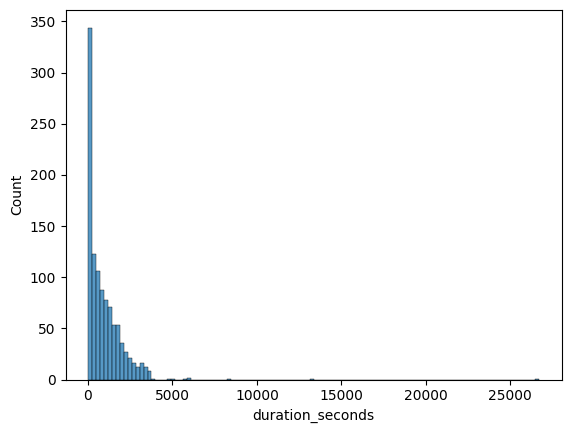

In [211]:
sns.histplot(video_dim, x="duration_seconds")

### licensed_content

In [212]:
video_dim["licensed_content"].value_counts()

licensed_content
True     987
False     86
Name: count, dtype: int64

### made_for_kids

In [213]:
video_dim["made_for_kids"].value_counts()

made_for_kids
False    1068
True        5
Name: count, dtype: int64

### published_at

<Axes: xlabel='published_at', ylabel='Count'>

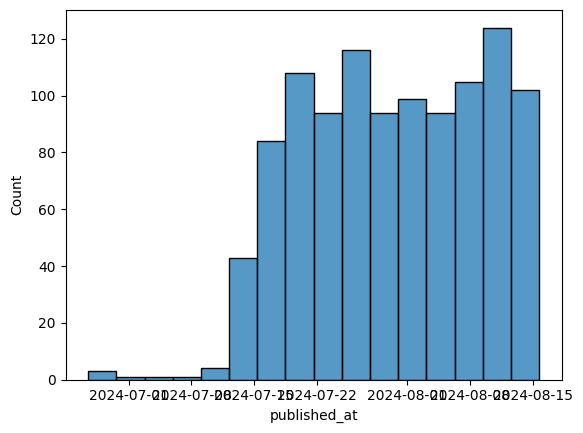

In [214]:
sns.histplot(video_dim, x="published_at")

### category_id

In [215]:
video_dim["category_id"].value_counts()

category_id
20    217
17    213
24    200
10    134
22     94
25     55
1      40
2      28
23     27
28     21
26     17
27     17
19      5
15      3
29      2
Name: count, dtype: int64

## channel_dim

In [216]:
channel_dim.shape

(763, 3)

In [217]:
channel_dim.dtypes

channel_id                  object
channel_name                object
created_datetime    datetime64[ns]
dtype: object

In [218]:
channel_dim.describe()

,created_datetime
count,763
mean,2014-08-17 01:36:55.704128
min,2005-06-16 12:09:27
25%,2010-07-31 10:40:19
50%,2014-10-24 08:37:28
75%,2019-01-06 21:13:08
max,2024-07-19 21:40:21.622480


### channel_id

In [219]:
channel_dim["channel_id"].sample(15)

550    UCToxKVrkEuAONR4rFIJ_DyQ
158    UClcqpZhHYcoRADrYmaGqVZA
694    UCuqJJN6Gfg02KaWLaWLB-4Q
271    UCSWoppsVL0TLxFQ2qP_DLqQ
515    UC6ktP3PLU5sAJxN9Rb0TALg
488    UCAMPco9PqjBbI_MLsDOO4Jw
514    UCeekxg1vju_sjIK9KjJJLYg
144    UChmpTxQ0Gp8KEJKsqzeg9Lg
747    UCs1pApqJNPZBcPcDjEWn6MA
656    UCaoTOpfjVfdm_XlYvwbVicQ
380    UCFrVj6wBM42y3XuKCAj8n5A
499    UCBNnILlexKYtJu-EGUvq_iA
373    UCmxURUIJXKnoC7_i1fPhs7Q
367    UCQJudtC0Pn7_LlI0w0rXamw
13     UCx-KWLTKlB83hDI6UKECtJQ
Name: channel_id, dtype: object

In [220]:
channel_dim["channel_id"].apply(lambda x: len(x)).value_counts()

channel_id
24    763
Name: count, dtype: int64

### channel_name

In [221]:
channel_dim["channel_name"].sample(15)

599        President Chay
589            Doni Bobes
720     DVV Entertainment
369    Sturniolo Triplets
742          PrestonPlayz
321               MGKVEVO
202    Telemundo Deportes
22           madelineargy
41        Nick DiGiovanni
740       DukeDennis LIVE
198         MandJTV Plays
516     Quenlin Blackwell
181      9 News Australia
327             Chevrolet
68              BANGTANTV
Name: channel_name, dtype: object

In [222]:
channel_dim["channel_name"].apply(lambda x: len(x)).value_counts()

channel_name
10    65
11    64
12    61
13    60
14    54
15    50
7     47
8     41
9     40
17    35
16    34
5     30
6     27
19    25
18    21
3     20
20    19
4     16
24     7
26     7
21     6
22     6
23     5
27     4
31     3
25     3
28     3
34     2
2      2
38     1
50     1
37     1
36     1
29     1
35     1
Name: count, dtype: int64

### created_datetime

<Axes: xlabel='created_datetime', ylabel='Count'>

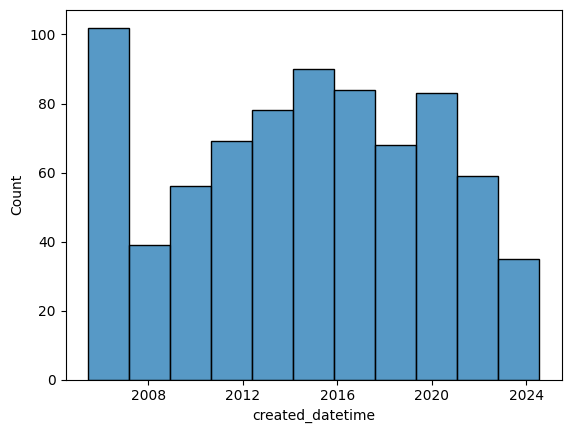

In [223]:
sns.histplot(channel_dim, x="created_datetime")

## categories_dim

In [224]:
print(categories_dim)

    category_id          category_name
0             1       Film & Animation
1             2       Autos & Vehicles
2            10                  Music
3            15         Pets & Animals
4            17                 Sports
5            18           Short Movies
6            19        Travel & Events
7            20                 Gaming
8            21          Videoblogging
9            22         People & Blogs
10           23                 Comedy
11           24          Entertainment
12           25        News & Politics
13           26          Howto & Style
14           27              Education
15           28   Science & Technology
16           29  Nonprofits & Activism
17           30                 Movies
18           31        Anime/Animation
19           32       Action/Adventure
20           33               Classics
21           34                 Comedy
22           35            Documentary
23           36                  Drama
24           37          

# Data Preparation
## Combine video_fact, video_dim, and categories_dim

In [225]:
video_all = (video_fact.merge(video_dim, on="video_id", how="inner")
             .merge(categories_dim, on="category_id", how="inner"))

In [226]:
video_all.rename(columns={"collected_at":"video_collected_dt", "published_at":"video_published_dt"}, inplace=True)

In [227]:
video_all.shape, video_all.columns

((130042, 15),
 Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
        'num_comments', 'channel_id', 'video_title', 'video_description',
        'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
        'video_published_dt', 'category_id', 'category_name'],
       dtype='object'))

## Combine channel_fact and channel_dim

In [228]:
channel_all = channel_fact.merge(channel_dim, on="channel_id", how="inner")

In [229]:
channel_all.rename(columns={"collected_at":"channel_collected_dt", "created_datetime":"channel_created_dt"}, inplace=True)

In [230]:
channel_all.shape, channel_all.columns

((101382, 7),
 Index(['channel_collected_dt', 'channel_id', 'channel_total_views',
        'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt'],
       dtype='object'))

## Join video and channel data

In [231]:
channel_all["collected_date"] = channel_all["channel_collected_dt"].dt.date
channel_all["collected_hour"] = channel_all["channel_collected_dt"].dt.hour
channel_all[["collected_date", "collected_hour"]].head()

,collected_date,collected_hour
0,2024-07-20,21
1,2024-07-21,0
2,2024-07-21,3
3,2024-07-21,6
4,2024-07-21,9


In [232]:
video_all["collected_date"] = video_all["video_collected_dt"].dt.date
video_all["collected_hour"] = video_all["video_collected_dt"].dt.hour
video_all[["collected_date", "collected_hour"]].head()

,collected_date,collected_hour
0,2024-07-20,21
1,2024-07-21,0
2,2024-07-21,3
3,2024-07-21,6
4,2024-07-21,9


In [250]:
all = video_all.merge(channel_all, on=["channel_id", "collected_date", "collected_hour"], how="left", suffixes=["_video", "_channel"])

In [251]:
all.isna().sum()

video_collected_dt      0
video_id                0
num_views               0
num_likes               0
num_comments            0
channel_id              0
video_title             0
video_description       0
num_tags                0
duration_seconds        0
licensed_content        0
made_for_kids           0
video_published_dt      0
category_id             0
category_name           0
collected_date          0
collected_hour          0
channel_collected_dt    0
channel_total_views     0
num_subscribers         0
num_videos              0
channel_name            0
channel_created_dt      0
dtype: int64

In [252]:
all.head()

,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,category_id,category_name,collected_date,collected_hour,channel_collected_dt,channel_total_views,num_subscribers,num_videos,channel_name,channel_created_dt
0,2024-07-20 21:00:06.211863,laNA2HgwYXU,7023341,334132,16936,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-20,21,2024-07-20 21:00:07.479465,828829584,4560000,319,Ryan Reynolds,2015-11-03 22:28:21
1,2024-07-21 00:00:05.864281,laNA2HgwYXU,7293604,339515,17160,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-21,0,2024-07-21 00:00:07.262266,828829584,4560000,319,Ryan Reynolds,2015-11-03 22:28:21
2,2024-07-21 03:00:05.532334,laNA2HgwYXU,7541497,344200,17332,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-21,3,2024-07-21 03:00:06.908555,828829584,4560000,319,Ryan Reynolds,2015-11-03 22:28:21
3,2024-07-21 06:00:06.161407,laNA2HgwYXU,7757614,348594,17430,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-21,6,2024-07-21 06:00:07.605247,832556785,4560000,319,Ryan Reynolds,2015-11-03 22:28:21
4,2024-07-21 09:00:05.730932,laNA2HgwYXU,7965163,352343,17554,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,24,Entertainment,2024-07-21,9,2024-07-21 09:00:07.113590,832556785,4560000,319,Ryan Reynolds,2015-11-03 22:28:21


## Datetime feature engineering

In [253]:
all["channel_days_since_created"] = (all["channel_created_dt"] - all["channel_collected_dt"])/pd.Timedelta("-1d")
all["days_since_published"] = (all["video_published_dt"] - all["video_collected_dt"])/pd.Timedelta("-1d")

In [254]:
all[["days_since_published", "video_published_dt", "video_collected_dt"]].head(15)

,days_since_published,video_published_dt,video_collected_dt
0,1.294111,2024-07-19 13:56:35,2024-07-20 21:00:06.211863
1,1.419107,2024-07-19 13:56:35,2024-07-21 00:00:05.864281
2,1.544103,2024-07-19 13:56:35,2024-07-21 03:00:05.532334
3,1.669111,2024-07-19 13:56:35,2024-07-21 06:00:06.161407
4,1.794106,2024-07-19 13:56:35,2024-07-21 09:00:05.730932
5,1.919100,2024-07-19 13:56:35,2024-07-21 12:00:05.212394
6,2.044106,2024-07-19 13:56:35,2024-07-21 15:00:05.741071
7,2.169098,2024-07-19 13:56:35,2024-07-21 18:00:05.102443
8,2.294106,2024-07-19 13:56:35,2024-07-21 21:00:05.719201
9,2.419104,2024-07-19 13:56:35,2024-07-22 00:00:05.624785


In [255]:
all[["channel_days_since_created", "channel_created_dt", "channel_collected_dt"]].head(15)

,channel_days_since_created,channel_created_dt,channel_collected_dt
0,3181.938732,2015-11-03 22:28:21,2024-07-20 21:00:07.479465
1,3182.063730,2015-11-03 22:28:21,2024-07-21 00:00:07.262266
2,3182.188726,2015-11-03 22:28:21,2024-07-21 03:00:06.908555
3,3182.313734,2015-11-03 22:28:21,2024-07-21 06:00:07.605247
4,3182.438728,2015-11-03 22:28:21,2024-07-21 09:00:07.113590
5,3182.563722,2015-11-03 22:28:21,2024-07-21 12:00:06.562954
6,3182.688728,2015-11-03 22:28:21,2024-07-21 15:00:07.088739
7,3182.813721,2015-11-03 22:28:21,2024-07-21 18:00:06.507693
8,3182.938729,2015-11-03 22:28:21,2024-07-21 21:00:07.179999
9,3183.063727,2015-11-03 22:28:21,2024-07-22 00:00:07.050279


In [256]:
first_time = all[["video_id", "video_collected_dt"]].groupby("video_id").min()
first_time.columns = ["first_time_collected"]
first_time.reset_index(inplace=True)
first_time

,video_id,first_time_collected
0,--hnj1cNLL4,2024-08-12 06:00:05.491753
1,-74HbNnmf_s,2024-07-21 00:00:05.864281
2,-F3RKk9srG4,2024-07-31 21:00:05.451524
3,-LNKtfeHP4Y,2024-08-14 00:00:06.264630
4,-Q1XbBENTZI,2024-07-30 15:00:05.640735
...,...,...
1068,zcpKxn4Klgs,2024-07-20 21:00:06.211863
1069,zdkhb5wjH28,2024-07-31 18:00:05.529008
1070,zlr9XnURJx4,2024-07-22 12:00:05.746991
1071,zsYlULcSe4k,2024-08-12 09:00:06.098406


In [257]:
all = all.merge(first_time, on="video_id", how="left")
all["first_time_collected"]

0        2024-07-20 21:00:06.211863
1        2024-07-20 21:00:06.211863
2        2024-07-20 21:00:06.211863
3        2024-07-20 21:00:06.211863
4        2024-07-20 21:00:06.211863
                    ...            
130037   2024-08-13 15:00:05.973600
130038   2024-08-13 15:00:05.973600
130039   2024-08-13 15:00:05.973600
130040   2024-08-13 15:00:05.973600
130041   2024-08-13 15:00:05.973600
Name: first_time_collected, Length: 130042, dtype: datetime64[ns]

In [259]:
all["days_since_first_collected"] = (all["first_time_collected"] - all["video_collected_dt"])/pd.Timedelta("-1d")
all["days_since_first_collected"] 

0        -0.000000
1         0.124996
2         0.249992
3         0.374999
4         0.499994
            ...   
130037    1.749990
130038    1.874998
130039    2.000005
130040    2.124999
130041    2.249994
Name: days_since_first_collected, Length: 130042, dtype: float64

In [260]:
all.dtypes

video_collected_dt            datetime64[ns]
video_id                              object
num_views                              int64
num_likes                              int64
num_comments                           int64
channel_id                            object
video_title                           object
video_description                     object
num_tags                               int64
duration_seconds                       int64
licensed_content                        bool
made_for_kids                           bool
video_published_dt            datetime64[ns]
category_id                            int64
category_name                         object
collected_date                        object
collected_hour                         int32
channel_collected_dt          datetime64[ns]
channel_total_views                    int64
num_subscribers                        int64
num_videos                             int64
channel_name                          object
channel_cr

## String feature engineering

In [261]:
all["video_title_len"] = all["video_title"].apply(lambda x: len(x))
all["video_description_len"] = all["video_description"].apply(lambda x: len(x))

In [262]:
# do this so it can be saved to csv
all["video_description"] = all["video_description"].apply(lambda x: x.replace("\r", "\\r").replace("\n", "\\n"))

In [263]:
all.shape

(130042, 29)

In [264]:
all.columns

Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
       'num_comments', 'channel_id', 'video_title', 'video_description',
       'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
       'video_published_dt', 'category_id', 'category_name', 'collected_date',
       'collected_hour', 'channel_collected_dt', 'channel_total_views',
       'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt',
       'channel_days_since_created', 'days_since_published',
       'first_time_collected', 'days_since_first_collected', 'video_title_len',
       'video_description_len'],
      dtype='object')

In [313]:
week1 = all.groupby("video_id").nth((0, 8, 16, 24, 32, 40, 48, 56))
week1.head(10)

,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,num_subscribers,num_videos,channel_name,channel_created_dt,channel_days_since_created,days_since_published,first_time_collected,days_since_first_collected,video_title_len,video_description_len
0,2024-07-20 21:00:06.211863,laNA2HgwYXU,7023341,334132,16936,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4560000,319,Ryan Reynolds,2015-11-03 22:28:21,3181.938732,1.294111,2024-07-20 21:00:06.211863,-0.000000,36,63
8,2024-07-21 21:00:05.719201,laNA2HgwYXU,8615067,363859,17933,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4560000,319,Ryan Reynolds,2015-11-03 22:28:21,3182.938729,2.294106,2024-07-20 21:00:06.211863,0.999994,36,63
16,2024-07-22 21:00:05.478038,laNA2HgwYXU,9212732,381259,18333,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4570000,320,Ryan Reynolds,2015-11-03 22:28:21,3183.938728,3.294103,2024-07-20 21:00:06.211863,1.999992,36,63
24,2024-07-23 21:00:05.087203,laNA2HgwYXU,9529188,390656,18545,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4570000,320,Ryan Reynolds,2015-11-03 22:28:21,3184.938724,4.294098,2024-07-20 21:00:06.211863,2.999987,36,63
32,2024-07-24 21:00:05.431902,laNA2HgwYXU,9792057,396990,18537,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4570000,320,Ryan Reynolds,2015-11-03 22:28:21,3185.938731,5.294102,2024-07-20 21:00:06.211863,3.999991,36,63
40,2024-07-25 21:00:05.346506,laNA2HgwYXU,9973057,400890,18671,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4570000,320,Ryan Reynolds,2015-11-03 22:28:21,3186.938730,6.294101,2024-07-20 21:00:06.211863,4.999990,36,63
48,2024-07-26 21:00:06.112719,laNA2HgwYXU,10098284,403220,18759,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4580000,321,Ryan Reynolds,2015-11-03 22:28:21,3187.938740,7.294110,2024-07-20 21:00:06.211863,5.999999,36,63
56,2024-07-27 21:00:05.811850,laNA2HgwYXU,10178441,404423,18802,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4580000,321,Ryan Reynolds,2015-11-03 22:28:21,3188.938737,8.294107,2024-07-20 21:00:06.211863,6.999995,36,63
209,2024-07-20 21:00:06.211863,u_as_PygtDc,1022746,46145,4234,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,...,3890000,776,HeavyDSparks,2015-05-01 22:33:04,3367.935457,0.938880,2024-07-20 21:00:06.211863,-0.000000,52,1036
217,2024-07-21 21:00:05.719201,u_as_PygtDc,1387795,54569,5031,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,...,3890000,777,HeavyDSparks,2015-05-01 22:33:04,3368.935453,1.938874,2024-07-20 21:00:06.211863,0.999994,52,1036


In [314]:
week1["days_since_first_collected"] = week1["days_since_first_collected"].round()
week1.head()

,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,num_subscribers,num_videos,channel_name,channel_created_dt,channel_days_since_created,days_since_published,first_time_collected,days_since_first_collected,video_title_len,video_description_len
0,2024-07-20 21:00:06.211863,laNA2HgwYXU,7023341,334132,16936,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4560000,319,Ryan Reynolds,2015-11-03 22:28:21,3181.938732,1.294111,2024-07-20 21:00:06.211863,-0.0,36,63
8,2024-07-21 21:00:05.719201,laNA2HgwYXU,8615067,363859,17933,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4560000,319,Ryan Reynolds,2015-11-03 22:28:21,3182.938729,2.294106,2024-07-20 21:00:06.211863,1.0,36,63
16,2024-07-22 21:00:05.478038,laNA2HgwYXU,9212732,381259,18333,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4570000,320,Ryan Reynolds,2015-11-03 22:28:21,3183.938728,3.294103,2024-07-20 21:00:06.211863,2.0,36,63
24,2024-07-23 21:00:05.087203,laNA2HgwYXU,9529188,390656,18545,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4570000,320,Ryan Reynolds,2015-11-03 22:28:21,3184.938724,4.294098,2024-07-20 21:00:06.211863,3.0,36,63
32,2024-07-24 21:00:05.431902,laNA2HgwYXU,9792057,396990,18537,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4570000,320,Ryan Reynolds,2015-11-03 22:28:21,3185.938731,5.294102,2024-07-20 21:00:06.211863,4.0,36,63


In [315]:
week1["days_since_first_collected"].value_counts()

days_since_first_collected
-0.0    1073
 1.0    1039
 2.0     999
 3.0     974
 4.0     920
 5.0     884
 6.0     841
 7.0     813
Name: count, dtype: int64

In [317]:
week1.shape

(7543, 29)

In [316]:
week1.to_csv("week1_time_series.csv", index=False)

## Only get stats for the first time point, time point one day after, and time point one week after

In [267]:
# first time point
first = all.groupby("video_id").nth(0)
print(first.shape)
first.head()

(1073, 29)


,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,num_subscribers,num_videos,channel_name,channel_created_dt,channel_days_since_created,days_since_published,first_time_collected,days_since_first_collected,video_title_len,video_description_len
0,2024-07-20 21:00:06.211863,laNA2HgwYXU,7023341,334132,16936,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4560000,319,Ryan Reynolds,2015-11-03 22:28:21,3181.938732,1.294111,2024-07-20 21:00:06.211863,-0.0,36,63
209,2024-07-20 21:00:06.211863,u_as_PygtDc,1022746,46145,4234,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,...,3890000,776,HeavyDSparks,2015-05-01 22:33:04,3367.935457,0.938880,2024-07-20 21:00:06.211863,-0.0,52,1036
418,2024-07-20 21:00:06.211863,Qn1UJssT-mU,13106958,716571,57805,UCsSsgPaZ2GSmO6il8Cb5iGA,skibidi toilet 76 (part 2),cameramen attempt to escape city\n\nfull-scree...,7,268,...,42900000,299,DaFuq!?Boom!,2016-06-06 15:19:28,2966.236568,1.666484,2024-07-20 21:00:06.211863,-0.0,26,501
627,2024-07-20 21:00:06.211863,H-c1bAk9Soc,535473,25595,1943,UCOgGAfSUy5LvEyVS_LF5kdw,Brits try Texas Ballpark food!,"Get 4 months extra on a 2 year plan, plus up t...",63,876,...,3980000,836,JOLLY,2015-10-07 18:25:54,3209.107100,1.228880,2024-07-20 21:00:06.211863,-0.0,30,970
836,2024-07-20 21:00:06.211863,7Nk5C6o3PkQ,2272245,104098,4229,UCPD_bxCRGpmmeQcbe2kpPaA,Childish Gambino Goes On a Vision Quest While ...,"Donald Glover—a.k.a., Childish Gambino—is a fi...",25,1393,...,13600000,1691,First We Feast,2014-02-28 21:48:23,3794.966487,2.249945,2024-07-20 21:00:06.211863,-0.0,75,1357


In [268]:
# one day after first time point
oneday = all.groupby("video_id").nth(8)
print(oneday.shape)
oneday.head()

(1039, 29)


,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,num_subscribers,num_videos,channel_name,channel_created_dt,channel_days_since_created,days_since_published,first_time_collected,days_since_first_collected,video_title_len,video_description_len
8,2024-07-21 21:00:05.719201,laNA2HgwYXU,8615067,363859,17933,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4560000,319,Ryan Reynolds,2015-11-03 22:28:21,3182.938729,2.294106,2024-07-20 21:00:06.211863,0.999994,36,63
217,2024-07-21 21:00:05.719201,u_as_PygtDc,1387795,54569,5031,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,...,3890000,777,HeavyDSparks,2015-05-01 22:33:04,3368.935453,1.938874,2024-07-20 21:00:06.211863,0.999994,52,1036
426,2024-07-21 21:00:05.719201,Qn1UJssT-mU,14409552,738857,58807,UCsSsgPaZ2GSmO6il8Cb5iGA,skibidi toilet 76 (part 2),cameramen attempt to escape city\n\nfull-scree...,7,268,...,42900000,299,DaFuq!?Boom!,2016-06-06 15:19:28,2967.236565,2.666478,2024-07-20 21:00:06.211863,0.999994,26,501
635,2024-07-21 21:00:05.719201,H-c1bAk9Soc,671950,29551,2178,UCOgGAfSUy5LvEyVS_LF5kdw,Brits try Texas Ballpark food!,"Get 4 months extra on a 2 year plan, plus up t...",63,876,...,3980000,836,JOLLY,2015-10-07 18:25:54,3210.107097,2.228874,2024-07-20 21:00:06.211863,0.999994,30,970
844,2024-07-21 21:00:05.719201,7Nk5C6o3PkQ,2621584,115550,4601,UCPD_bxCRGpmmeQcbe2kpPaA,Childish Gambino Goes On a Vision Quest While ...,"Donald Glover—a.k.a., Childish Gambino—is a fi...",25,1393,...,13600000,1692,First We Feast,2014-02-28 21:48:23,3795.966484,3.249939,2024-07-20 21:00:06.211863,0.999994,75,1357


In [269]:
# one week after the first time point
oneweek = all.groupby("video_id").nth(56)
print(oneweek.shape)
oneweek.head()

(813, 29)


,video_collected_dt,video_id,num_views,num_likes,num_comments,channel_id,video_title,video_description,num_tags,duration_seconds,...,num_subscribers,num_videos,channel_name,channel_created_dt,channel_days_since_created,days_since_published,first_time_collected,days_since_first_collected,video_title_len,video_description_len
56,2024-07-27 21:00:05.811850,laNA2HgwYXU,10178441,404423,18802,UCA3-nIYWu4PTWkb6NwhEpzg,Deadpool & Wolverine | Final Trailer,This isn’t the movie you think it is. #Deadpoo...,0,122,...,4580000,321,Ryan Reynolds,2015-11-03 22:28:21,3188.938737,8.294107,2024-07-20 21:00:06.211863,6.999995,36,63
265,2024-07-27 21:00:05.811850,u_as_PygtDc,2019230,70374,6578,UCGTKwjs1ctvgwCRa67RNO-Q,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,Thanks to ARMRA Colostrum for sponsoring this ...,44,1657,...,3900000,783,HeavyDSparks,2015-05-01 22:33:04,3374.935462,7.938875,2024-07-20 21:00:06.211863,6.999995,52,1036
474,2024-07-27 21:00:05.811850,Qn1UJssT-mU,16876175,780063,60523,UCsSsgPaZ2GSmO6il8Cb5iGA,skibidi toilet 76 (part 2),cameramen attempt to escape city\n\nfull-scree...,7,268,...,43000000,299,DaFuq!?Boom!,2016-06-06 15:19:28,2973.236573,8.666479,2024-07-20 21:00:06.211863,6.999995,26,501
683,2024-07-27 21:00:05.811850,H-c1bAk9Soc,904825,36447,2624,UCOgGAfSUy5LvEyVS_LF5kdw,Brits try Texas Ballpark food!,"Get 4 months extra on a 2 year plan, plus up t...",63,876,...,3990000,840,JOLLY,2015-10-07 18:25:54,3216.107105,8.228875,2024-07-20 21:00:06.211863,6.999995,30,970
892,2024-07-27 21:00:05.811850,7Nk5C6o3PkQ,3473190,144126,5234,UCPD_bxCRGpmmeQcbe2kpPaA,Childish Gambino Goes On a Vision Quest While ...,"Donald Glover—a.k.a., Childish Gambino—is a fi...",25,1393,...,13700000,1702,First We Feast,2014-02-28 21:48:23,3801.966492,9.249940,2024-07-20 21:00:06.211863,6.999995,75,1357


# Questions

## How well does a video need to do to show up on "most popular"?

In [270]:
first.columns

Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
       'num_comments', 'channel_id', 'video_title', 'video_description',
       'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
       'video_published_dt', 'category_id', 'category_name', 'collected_date',
       'collected_hour', 'channel_collected_dt', 'channel_total_views',
       'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt',
       'channel_days_since_created', 'days_since_published',
       'first_time_collected', 'days_since_first_collected', 'video_title_len',
       'video_description_len'],
      dtype='object')

In [271]:
cols = ["num_views", "num_likes", "num_comments", "num_tags", "duration_seconds", "days_since_published", "video_title_len", "video_description_len"]
first[cols].describe().apply(lambda x: x.apply('{0:.5f}'.format)) # gets rid of scientific notation

,num_views,num_likes,num_comments,num_tags,duration_seconds,days_since_published,video_title_len,video_description_len
count,1073.00000,1073.00000,1073.00000,1073.00000,1073.00000,1073.00000,1073.00000,1073.00000
mean,1247611.69897,61194.52283,4459.20130,15.90680,969.61230,1.39088,53.90308,1009.42218
std,6396259.50302,340613.03374,18230.20467,12.79192,1288.05634,2.15512,21.99546,815.98474
min,30340.00000,0.00000,0.00000,0.00000,13.00000,0.08270,4.00000,0.00000
25%,216486.00000,7884.00000,718.00000,4.00000,198.00000,0.47068,38.00000,442.00000
50%,420304.00000,17779.00000,1543.00000,15.00000,609.00000,0.78797,50.00000,807.00000
75%,894317.00000,42298.00000,3380.00000,25.00000,1398.00000,1.05717,69.00000,1321.00000
max,159559695.00000,7392365.00000,337068.00000,65.00000,26709.00000,24.35933,100.00000,4995.00000


- The least viewed video had 30k views and the most viewed had 159 million before it was "most popular"
- Some "most popular" videos have no likes, no comments, and/or no tags.
- Videos can be as few as 22 seconds long or as many as 13000 seconds long (3.6 hrs)
- 75% of videos that show up on most popular have been out for less than 30 hours.

In [272]:
melted = first[cols].melt(var_name="column")
melted.sample(5)

,column,value
2439,num_comments,4454.0
7667,video_description_len,690.0
6877,video_title_len,13.0
3366,num_tags,20.0
445,num_views,108873.0


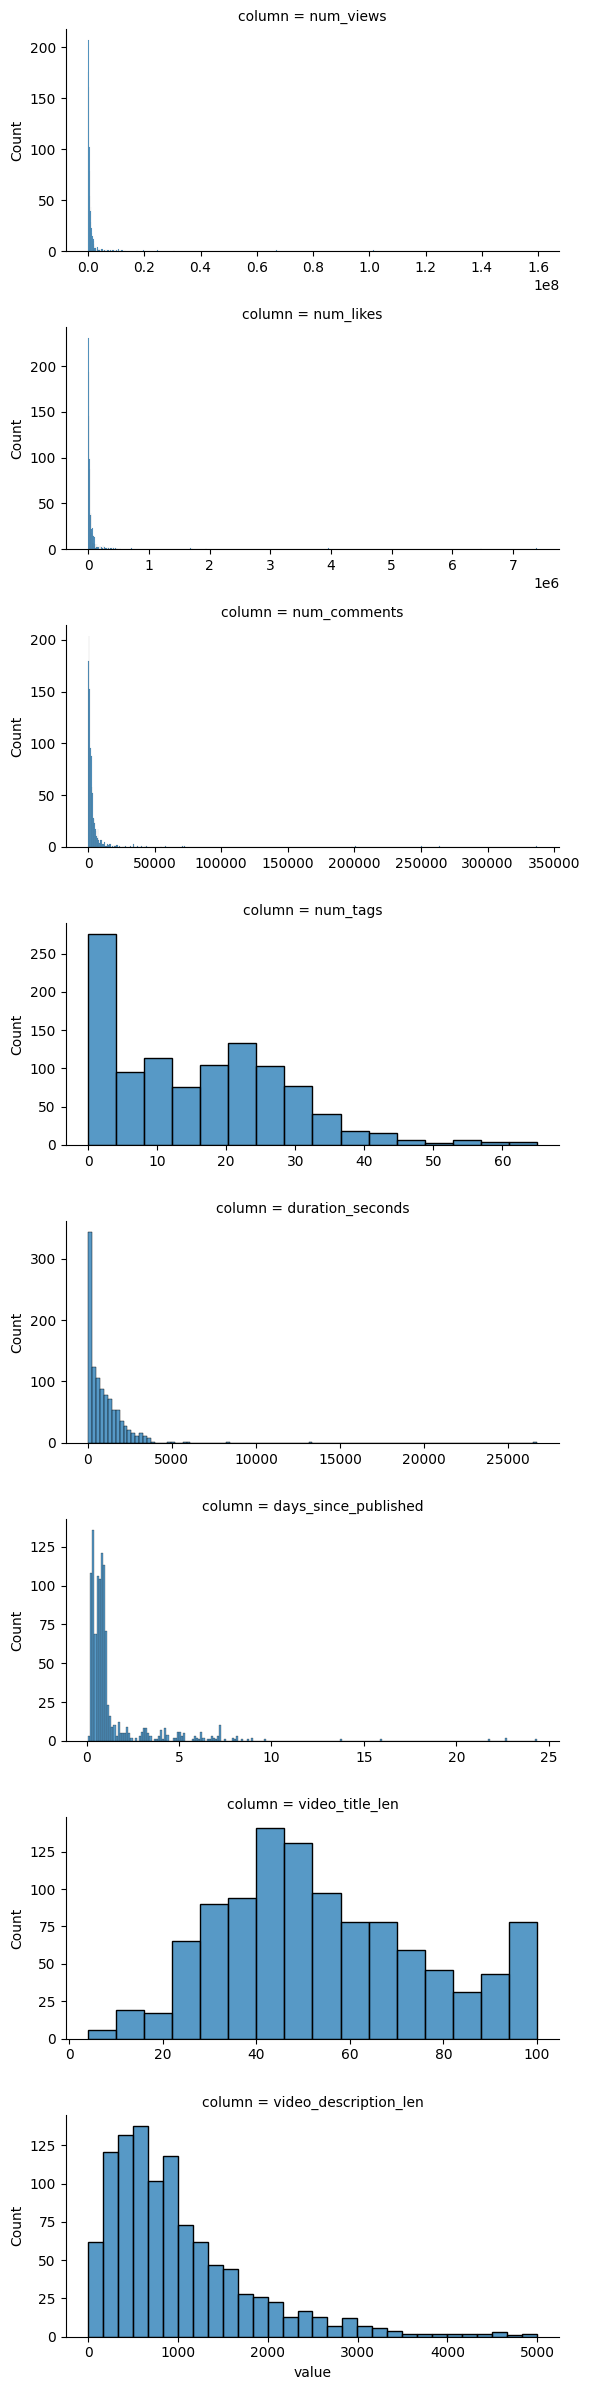

In [273]:
g = sns.FacetGrid(melted, row="column", sharey=False, sharex=False, aspect=2)
g.map_dataframe(sns.histplot, "value")

There are many outliers for views and comments and likes.

In [274]:
no_views = first.loc[first["num_views"] == 0]
no_views.shape[0]/first.shape[0] * 100

0.0

In [275]:
# how many videos have 0 likes, comments, or tags?
no_comments = first.loc[first["num_comments"] == 0]
no_comments.shape[0]/first.shape[0] * 100

2.3299161230195713

2% of videos have comments disabled

In [276]:
no_tags = first.loc[first["num_tags"] == 0]
no_tags.shape[0]/first.shape[0] * 100

16.495806150978567

17% of videos have no tags

In [277]:
no_likes = first.loc[first["num_likes"] == 0]
no_likes.shape[0]/first.shape[0] * 100

0.4659832246039142

.4% of videos have likes hidden

In [278]:
corr_cols = cols + ['made_for_kids', 'licensed_content']

<Axes: >

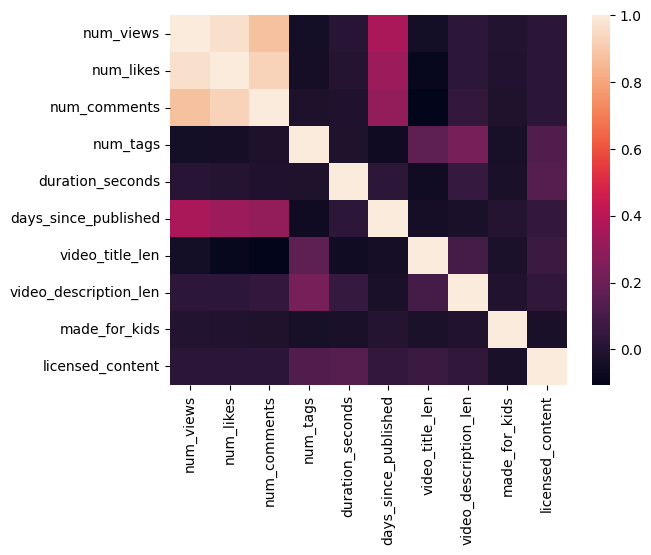

In [279]:
sns.heatmap(first[corr_cols].corr())

Views, likes, and comments are correlated, and there's a slight correlation between the video being out for longer and having more likes, views, and comments. Not surprising. The other variables seem to have no effect on views.

### Conclusion
There doesn't seem to be any specific level of performance for videos to show up on most popular. It's hard to even answer this question because I don't have any information on what the videos' stats looked like before they were on most popular.

## How much do views grow after one day and one week?
### One day growth

In [280]:
oneday.shape

(1039, 29)

In [281]:
growth_1day = first[["video_id", "num_views"]].merge(oneday[["video_id", "num_views"]],
                                                         on="video_id", 
                                                         how="inner", 
                                                         suffixes=("_first", "_1day"))
growth_1day

,video_id,num_views_first,num_views_1day
0,laNA2HgwYXU,7023341,8615067
1,u_as_PygtDc,1022746,1387795
2,Qn1UJssT-mU,13106958,14409552
3,H-c1bAk9Soc,535473,671950
4,7Nk5C6o3PkQ,2272245,2621584
...,...,...,...
1034,ZvQr87R3BqU,475184,821795
1035,QLI0XOFpK0A,1084317,2134099
1036,M3oT3-4sSOY,320529,973275
1037,OBXajYNKhbA,196242,457949


In [282]:
growth_1day["abs_growth"] = growth_1day["num_views_1day"] - growth_1day["num_views_first"]
growth_1day["pct_growth"] = growth_1day["abs_growth"] / growth_1day["num_views_first"]
growth_1day

,video_id,num_views_first,num_views_1day,abs_growth,pct_growth
0,laNA2HgwYXU,7023341,8615067,1591726,0.226634
1,u_as_PygtDc,1022746,1387795,365049,0.356930
2,Qn1UJssT-mU,13106958,14409552,1302594,0.099382
3,H-c1bAk9Soc,535473,671950,136477,0.254872
4,7Nk5C6o3PkQ,2272245,2621584,349339,0.153742
...,...,...,...,...,...
1034,ZvQr87R3BqU,475184,821795,346611,0.729425
1035,QLI0XOFpK0A,1084317,2134099,1049782,0.968150
1036,M3oT3-4sSOY,320529,973275,652746,2.036465
1037,OBXajYNKhbA,196242,457949,261707,1.333593


In [283]:
growth_1day.describe().apply(lambda x: x.apply('{0:.5f}'.format)) # gets rid of scientific notation

,num_views_first,num_views_1day,abs_growth,pct_growth
count,1039.00000,1039.00000,1039.00000,1039.00000
mean,1264006.27045,1737269.37729,473263.10683,0.70473
std,6496670.76935,7141171.17695,1723392.20000,0.89144
min,30340.00000,37392.00000,138.00000,0.00009
25%,220573.50000,350363.50000,81305.00000,0.22926
50%,421055.00000,663450.00000,178048.00000,0.45140
75%,895312.50000,1347834.00000,405785.50000,0.88328
max,159559695.00000,164670475.00000,48086405.00000,12.69989


After becoming most popular, videos grow by 447 thousand +/- 1.8 million in one day

### One week growth

In [284]:
oneweek.shape

(813, 29)

In [285]:
growth_1week = first[["video_id", "num_views"]].merge(oneweek[["video_id", "num_views"]],
                                                         on="video_id", 
                                                         how="inner", 
                                                         suffixes=("_first", "_1day"))
growth_1week

,video_id,num_views_first,num_views_1day
0,laNA2HgwYXU,7023341,10178441
1,u_as_PygtDc,1022746,2019230
2,Qn1UJssT-mU,13106958,16876175
3,H-c1bAk9Soc,535473,904825
4,7Nk5C6o3PkQ,2272245,3473190
...,...,...,...
808,EpTdAYlHpjo,254135,765977
809,uQ8yDdtoFj0,894317,1106033
810,KQFMB-Mf1LA,296079,1164978
811,1eafBVGTJQ8,114218,767587


In [286]:
growth_1week["abs_growth"] = growth_1week["num_views_1day"] - growth_1week["num_views_first"]
growth_1week["pct_growth"] = growth_1week["abs_growth"] / growth_1week["num_views_first"]
growth_1week

,video_id,num_views_first,num_views_1day,abs_growth,pct_growth
0,laNA2HgwYXU,7023341,10178441,3155100,0.449231
1,u_as_PygtDc,1022746,2019230,996484,0.974322
2,Qn1UJssT-mU,13106958,16876175,3769217,0.287574
3,H-c1bAk9Soc,535473,904825,369352,0.689768
4,7Nk5C6o3PkQ,2272245,3473190,1200945,0.528528
...,...,...,...,...,...
808,EpTdAYlHpjo,254135,765977,511842,2.014056
809,uQ8yDdtoFj0,894317,1106033,211716,0.236735
810,KQFMB-Mf1LA,296079,1164978,868899,2.934686
811,1eafBVGTJQ8,114218,767587,653369,5.720368


In [287]:
growth_1week.describe().apply(lambda x: x.apply('{0:.5f}'.format)) # gets rid of scientific notation

,num_views_first,num_views_1day,abs_growth,pct_growth
count,813.00000,813.00000,813.00000,813.00000
mean,1405895.35055,2669563.21525,1263667.86470,1.94552
std,7318277.24768,10217345.72124,4543844.05979,2.99370
min,30340.00000,46779.00000,-30232.00000,-0.08771
25%,224509.00000,542928.00000,206885.00000,0.51416
50%,428392.00000,1029504.00000,477883.00000,1.14671
75%,894317.00000,2053072.00000,1080780.00000,2.28911
max,159559695.00000,197363048.00000,104052284.00000,33.99143


Most popular videos grow by 1.1 million +/- 2.7 million in one week.

## What types of videos perform the best?
Judging based off one week performance

<Axes: >

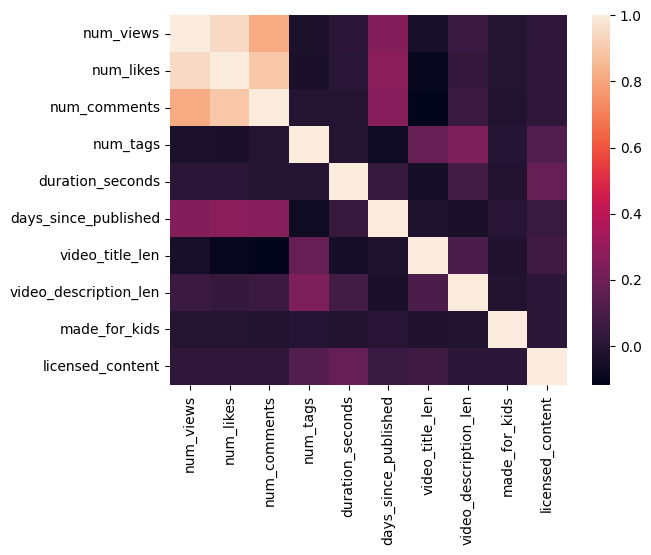

In [288]:
sns.heatmap(oneweek[corr_cols].corr())

In [289]:
best_categories = oneweek.groupby("category_name")["num_views"].median().sort_values(ascending=False)
best_categories = best_categories.reset_index()
best_categories.columns = ["category_name", "median_views"]
best_categories

,category_name,median_views
0,Science & Technology,2111504.0
1,Pets & Animals,1864318.0
2,Music,1825884.0
3,Film & Animation,1658921.0
4,Education,1574347.0
5,Comedy,1342634.0
6,Entertainment,1227854.0
7,News & Politics,1159853.0
8,Travel & Events,1106033.0
9,Sports,1000768.0


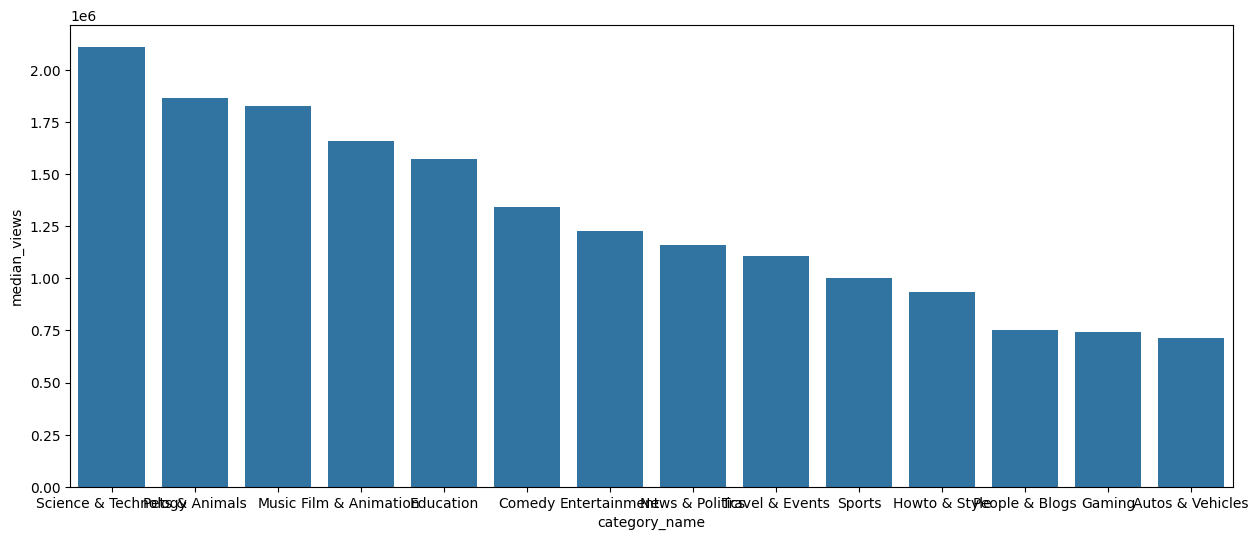

In [290]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(data=best_categories, x="category_name", y="median_views", ax=ax)

Music, Science & Technology, and Pets & Animals perform the best when removing outliers.

In [291]:
mean_best_cat = oneweek.groupby("category_name")["num_views"].agg(np.mean).sort_values(ascending=False)
mean_best_cat

category_name
Entertainment           5.284705e+06
Music                   4.809610e+06
Film & Animation        3.711244e+06
Science & Technology    2.822401e+06
Education               1.940554e+06
Pets & Animals          1.864318e+06
Comedy                  1.772430e+06
News & Politics         1.750924e+06
Sports                  1.714854e+06
Howto & Style           1.349142e+06
People & Blogs          1.321427e+06
Autos & Vehicles        1.090415e+06
Gaming                  1.089473e+06
Travel & Events         1.012866e+06
Name: num_views, dtype: float64

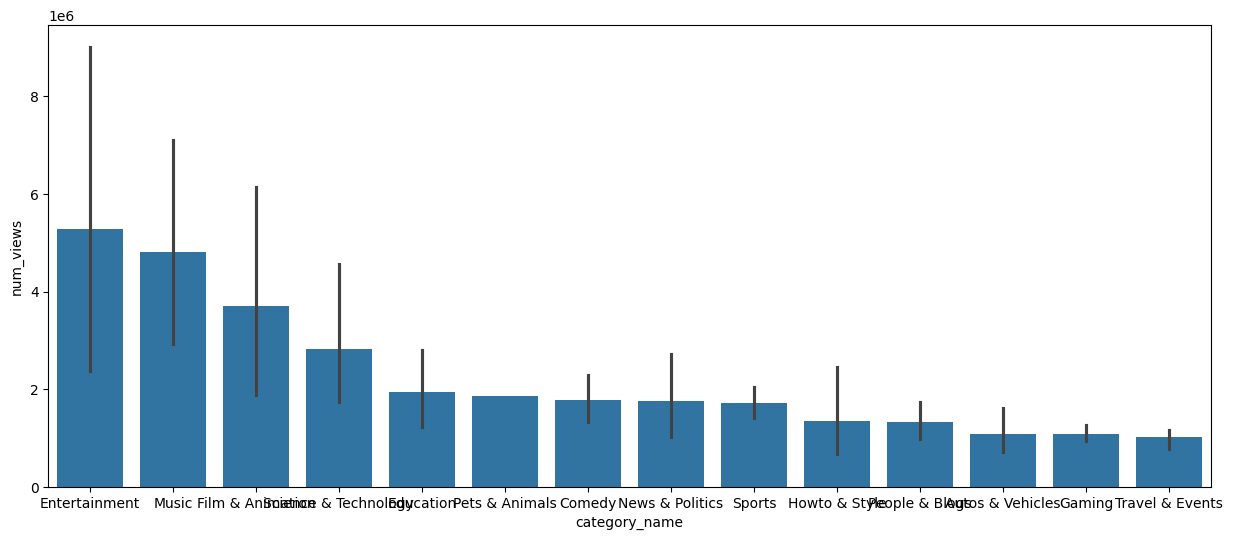

In [292]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(data=oneweek, x="category_name", y="num_views", order=mean_best_cat.index,
                 ax=ax)

Entertainment, Music, and Film & Animation dominate when looking at average views. They also have the largest variances.

## What types of channels perform the best?
Judging based off one week performance

In [293]:
corr_cols

['num_views',
 'num_likes',
 'num_comments',
 'num_tags',
 'duration_seconds',
 'days_since_published',
 'video_title_len',
 'video_description_len',
 'made_for_kids',
 'licensed_content']

In [294]:
oneweek.columns

Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
       'num_comments', 'channel_id', 'video_title', 'video_description',
       'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
       'video_published_dt', 'category_id', 'category_name', 'collected_date',
       'collected_hour', 'channel_collected_dt', 'channel_total_views',
       'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt',
       'channel_days_since_created', 'days_since_published',
       'first_time_collected', 'days_since_first_collected', 'video_title_len',
       'video_description_len'],
      dtype='object')

In [295]:
ch_corr_cols = ["num_views", "channel_total_views", "num_subscribers", "num_videos", "channel_days_since_created"]

<Axes: >

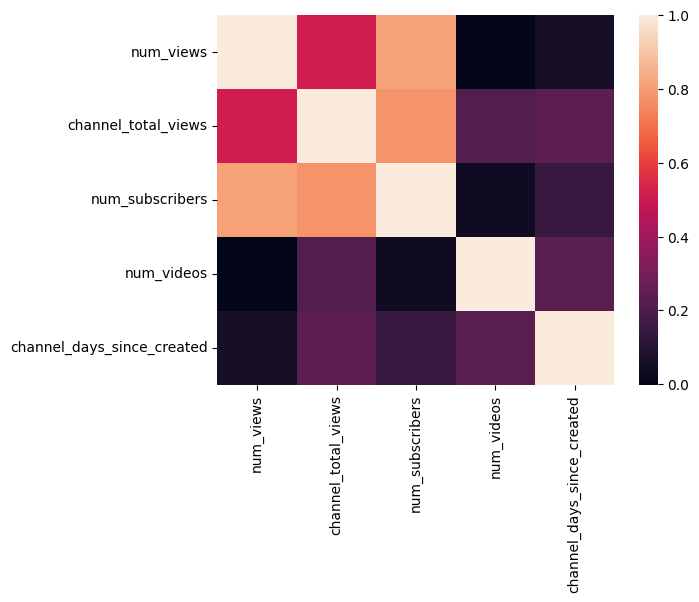

In [296]:
sns.heatmap(oneweek[ch_corr_cols].corr())

Age of the channel and number of uploaded videos do not correlate with views. Number of subscribers strongly correlates with views and total channel views correlated modestly with the number of views a video has 1 week after showing up on most popular.

## Is there a best day of week or time of day to upload?
Judging based off one week performance.

In [297]:
best_upload = pd.concat([oneweek["num_views"], oneweek["video_published_dt"].dt.dayofweek, oneweek["video_published_dt"].dt.hour], axis=1)
best_upload.columns = ["num_views", "published_dayofweek", "published_hourofday"]
best_upload

,num_views,published_dayofweek,published_hourofday
56,10178441,4,13
265,2019230,4,22
474,16876175,4,5
683,904825,4,15
892,3473190,3,15
...,...,...,...
129122,765977,2,14
129271,1106033,5,15
129480,1164978,5,15
129632,767587,2,12


In [298]:
day_dict = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}
best_upload["published_dayofweek"] = best_upload["published_dayofweek"].map(lambda x: day_dict[x])
best_upload

,num_views,published_dayofweek,published_hourofday
56,10178441,Friday,13
265,2019230,Friday,22
474,16876175,Friday,5
683,904825,Friday,15
892,3473190,Thursday,15
...,...,...,...
129122,765977,Wednesday,14
129271,1106033,Saturday,15
129480,1164978,Saturday,15
129632,767587,Wednesday,12


### Best day of week to upload

In [299]:
best_dayofweek = best_upload.groupby("published_dayofweek")["num_views"].median().sort_values(ascending=False)
best_dayofweek = best_dayofweek.reset_index()
best_dayofweek.columns = ["dayofweek", "median_views"]
best_dayofweek

,dayofweek,median_views
0,Friday,1626198.5
1,Saturday,1484062.0
2,Thursday,1053473.0
3,Sunday,1003965.0
4,Tuesday,891934.0
5,Monday,809235.5
6,Wednesday,776916.0


<Axes: xlabel='dayofweek', ylabel='median_views'>

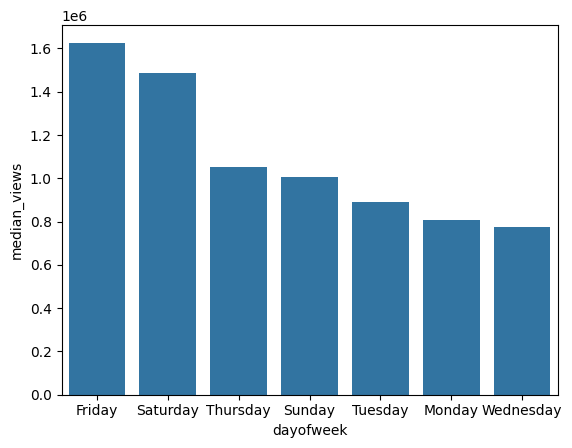

In [300]:
# fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=best_dayofweek, x="dayofweek", y="median_views")

Friday and Saturday uploads get the most views. Tuesday and Wednesday uploads get the least.

### Best hour of day to upload

In [301]:
best_hourofday = best_upload.groupby("published_hourofday")["num_views"].median().sort_values(ascending=False)
best_hourofday = best_hourofday.reset_index()
best_hourofday.columns = ["hourofday", "median_views"]
best_hourofday

,hourofday,median_views
0,1,1542333.0
1,13,1407079.0
2,7,1384634.0
3,19,1280089.0
4,16,1279101.0
5,5,1184118.5
6,9,1178531.0
7,4,1154343.0
8,14,1131380.5
9,17,1101376.5


9am, 1am, and 7am have the best performance.

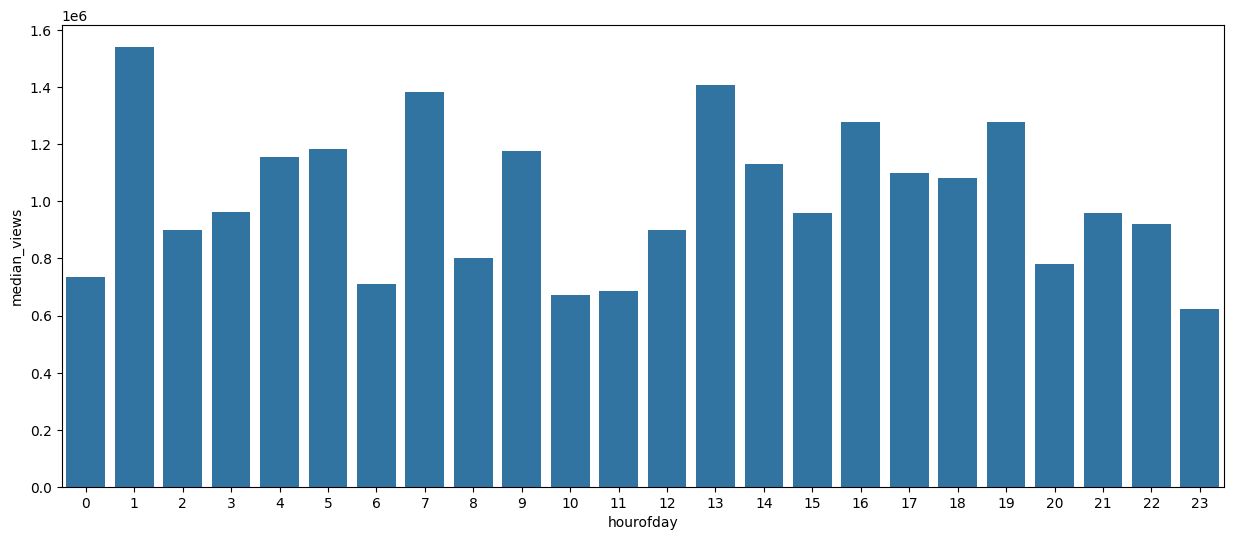

In [302]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(data=best_hourofday, x="hourofday", y="median_views", ax=ax)

# Save oneweek to use in tableau

In [303]:
oneweek.shape, oneweek.columns

((813, 29),
 Index(['video_collected_dt', 'video_id', 'num_views', 'num_likes',
        'num_comments', 'channel_id', 'video_title', 'video_description',
        'num_tags', 'duration_seconds', 'licensed_content', 'made_for_kids',
        'video_published_dt', 'category_id', 'category_name', 'collected_date',
        'collected_hour', 'channel_collected_dt', 'channel_total_views',
        'num_subscribers', 'num_videos', 'channel_name', 'channel_created_dt',
        'channel_days_since_created', 'days_since_published',
        'first_time_collected', 'days_since_first_collected', 'video_title_len',
        'video_description_len'],
       dtype='object'))

In [304]:
oneweek["video_description"].apply(lambda x: "\n" in x).sum()

0

In [305]:
oneweek["video_description"].apply(lambda x: "\r" in x).sum()

0

In [306]:
oneweek.to_csv("oneweek.csv", index=False)

In [307]:
corr_cols = ['num_views',
 'num_likes',
 'num_comments',
 'duration_seconds',
 'days_since_published',
 'num_tags',
 'video_title_len',
 'video_description_len',
 'made_for_kids',
 'licensed_content',
 "num_subscribers",
 "num_videos",
 "channel_total_views",
 "channel_days_since_created",
 ]

In [308]:
non_corr_cols = set(oneweek.columns) - set(corr_cols)
non_corr_cols

{'category_id',
 'category_name',
 'channel_collected_dt',
 'channel_created_dt',
 'channel_id',
 'channel_name',
 'collected_date',
 'collected_hour',
 'days_since_first_collected',
 'first_time_collected',
 'video_collected_dt',
 'video_description',
 'video_id',
 'video_published_dt',
 'video_title'}

In [309]:
oneweek.melt(id_vars=non_corr_cols)

,collected_hour,channel_name,channel_collected_dt,video_collected_dt,channel_created_dt,collected_date,channel_id,category_name,first_time_collected,video_description,video_published_dt,days_since_first_collected,video_id,video_title,category_id,variable,value
0,21,Ryan Reynolds,2024-07-27 21:00:07.899199,2024-07-27 21:00:05.811850,2015-11-03 22:28:21.000000,2024-07-27,UCA3-nIYWu4PTWkb6NwhEpzg,Entertainment,2024-07-20 21:00:06.211863,This isn’t the movie you think it is. #Deadpoo...,2024-07-19 13:56:35,6.999995,laNA2HgwYXU,Deadpool & Wolverine | Final Trailer,24,num_views,10178441.0
1,21,HeavyDSparks,2024-07-27 21:00:07.899199,2024-07-27 21:00:05.811850,2015-05-01 22:33:04.000000,2024-07-27,UCGTKwjs1ctvgwCRa67RNO-Q,Entertainment,2024-07-20 21:00:06.211863,Thanks to ARMRA Colostrum for sponsoring this ...,2024-07-19 22:28:07,6.999995,u_as_PygtDc,Uh Oh…My Boaterhome Might Actually Be a BUMMER...,24,num_views,2019230.0
2,21,DaFuq!?Boom!,2024-07-27 21:00:07.899199,2024-07-27 21:00:05.811850,2016-06-06 15:19:28.000000,2024-07-27,UCsSsgPaZ2GSmO6il8Cb5iGA,Entertainment,2024-07-20 21:00:06.211863,cameramen attempt to escape city\n\nfull-scree...,2024-07-19 05:00:22,6.999995,Qn1UJssT-mU,skibidi toilet 76 (part 2),24,num_views,16876175.0
3,21,JOLLY,2024-07-27 21:00:07.899199,2024-07-27 21:00:05.811850,2015-10-07 18:25:54.000000,2024-07-27,UCOgGAfSUy5LvEyVS_LF5kdw,Entertainment,2024-07-20 21:00:06.211863,"Get 4 months extra on a 2 year plan, plus up t...",2024-07-19 15:30:31,6.999995,H-c1bAk9Soc,Brits try Texas Ballpark food!,24,num_views,904825.0
4,21,First We Feast,2024-07-27 21:00:07.899199,2024-07-27 21:00:05.811850,2014-02-28 21:48:23.000000,2024-07-27,UCPD_bxCRGpmmeQcbe2kpPaA,Entertainment,2024-07-20 21:00:06.211863,"Donald Glover—a.k.a., Childish Gambino—is a fi...",2024-07-18 15:00:11,6.999995,7Nk5C6o3PkQ,Childish Gambino Goes On a Vision Quest While ...,24,num_views,3473190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11377,0,VINwiki,2024-08-15 00:00:10.308102,2024-08-15 00:00:06.203405,2016-05-30 18:10:46.000000,2024-08-15,UCefl-5pmhZmljwZTE2KrcdA,Autos & Vehicles,2024-08-08 00:00:05.614658,Find your dream car on AutoTempest - https://v...,2024-08-07 14:00:20,7.000007,EpTdAYlHpjo,I bought a Bugatti!,2,video_description_len,1064.0
11378,21,Kara and Nate,2024-07-27 21:00:07.899199,2024-07-27 21:00:05.811850,2015-12-08 23:23:36.000000,2024-07-27,UC4ijq8Cg-8zQKx8OH12dUSw,Travel & Events,2024-07-20 21:00:06.211863,Joshua Tree has the most unique airbnbs!! For ...,2024-07-13 15:00:53,6.999995,uQ8yDdtoFj0,What's Inside California's Craziest Airbnbs?,19,video_description_len,3319.0
11379,0,Kara and Nate,2024-08-04 00:00:08.652745,2024-08-04 00:00:05.801973,2015-12-08 23:23:36.000000,2024-08-04,UC4ijq8Cg-8zQKx8OH12dUSw,Travel & Events,2024-07-28 00:00:05.867683,We’re back in our van for the summer!! In this...,2024-07-27 15:00:17,6.999999,KQFMB-Mf1LA,Back to Van Life + a big announcement!,19,video_description_len,3002.0
11380,21,Universal Orlando Resort,2024-08-07 21:00:08.702708,2024-08-07 21:00:05.578715,2007-10-17 00:24:20.000000,2024-08-07,UCGl3kbSLHfKb3QeOYG7pAuA,Travel & Events,2024-07-31 21:00:05.451524,Explore the wonders of The Wizarding World of ...,2024-07-31 12:30:42,7.000001,1eafBVGTJQ8,Introducing The Wizarding World of Harry Potte...,19,video_description_len,863.0


In [310]:
oneweek.melt(id_vars=non_corr_cols).to_csv("pivoted_oneweek.csv", index=False)

In [311]:
oneweek.shape

(813, 29)